### 库与数据探索and 观察

In [1]:
import os, json
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models import resnet50
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor




In [3]:
# ✅ 1. 设置数据路径与设备
csv_path = "/mnt/e/code/plants-classification-conda/plant_multitask_dataset.csv"
organ_json = "/mnt/e/code/plants-classification-conda/organ_classes.json"
species_json = "/mnt/e/code/plants-classification-conda/species_classes.json"

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print("✅ 当前设备：", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


✅ 当前设备： NVIDIA GeForce RTX 3090


In [4]:
# ✅ 2. 读取数据
df_all = pd.read_csv(csv_path)
#df_sample = df_all.sample(n=20000, random_state=42)  # 小样本验证
# 保存这部分用于建模的数据
#df_sample.to_csv("plant_sample_20k.csv", index=False)

# 2. 从抽样数据中生成 organ 和 species 编码映射
#organ_classes = {name: idx for idx, name in enumerate(sorted(df_sample['organ'].unique()))}
#species_classes = {name: idx for idx, name in enumerate(sorted(df_sample['label'].unique()))}

# 3. 添加编码列
#df_sample['organ_id'] = df_sample['organ'].map(organ_classes)
#df_sample['species_id'] = df_sample['label'].map(species_classes)

# 4. 保存数据与映射
'''df_sample.to_csv("plant_subset_20k.csv", index=False)
with open("organ_classes_20k.json", "w", encoding="utf-8") as f:
    json.dump(organ_classes, f, ensure_ascii=False, indent=2)
with open("species_classes_20k.json", "w", encoding="utf-8") as f:
    json.dump(species_classes, f, ensure_ascii=False, indent=2)'''

# 必须重新编码标签
species_classes = {name: idx for idx, name in enumerate(sorted(df_all['label'].unique()))}
df_all['species_id'] = df_all['label'].map(species_classes)
df_all = df_all[df_all['species_id'].notnull()].copy()
df_all['species_id'] = df_all['species_id'].astype(int)

# 检查标签值范围
num_classes = len(species_classes)
assert df_all['species_id'].min() >= 0
assert df_all['species_id'].max() < num_classes


In [5]:
df_all.head()

,label,organ,image_path,organ_id,species_id,species_id_masked
0,Spathoglottis pubescens,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Sp...,1,3058,3058
1,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
2,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
3,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
4,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428


In [6]:
df_all.nunique()

label                   3467
organ                      4
image_path           1089470
organ_id                   4
species_id              3467
species_id_masked       3444
dtype: int64

In [87]:
print(df_all['organ_id'].nunique())
print(df_all['organ'].value_counts())

4
organ
leaf      531127
flower    417738
fruit      74864
bark       65741
Name: count, dtype: int64


In [ ]:
#!pip install matplotlib

In [15]:
from matplotlib import font_manager

# 选择其中一个路径作为 font_path
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # Noto 中文


# 注册字体
my_font = font_manager.FontProperties(fname=font_path)

label
Acer negundo               1000
Caesalpinia pulcherrima     999
Elaeagnus pungens           999
Sorbus aucuparia            999
Acer rubrum                 999
Name: count, dtype: int64


NameError: name 'my_font' is not defined

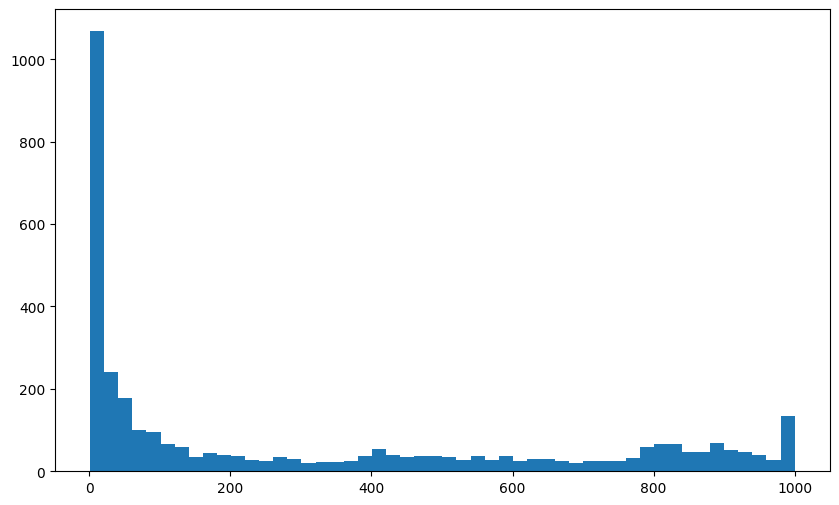

In [21]:
#数据统计与可视化

from collections import Counter
import matplotlib.pyplot as plt

# 统计每个植物物种的图像数量
species_counts = df_all['label'].value_counts()

# 显示前20个植物的图像数（可选）
print(species_counts.head())

# 可视化图像数量分布（直方图）
plt.figure(figsize=(10, 6))
plt.hist(species_counts.values, bins=50)
plt.xlabel("图像数量", fontproperties=my_font)
plt.ylabel("物种数量", fontproperties=my_font)
plt.title("每个植物物种的图像数量分布", fontproperties=my_font)
plt.grid(True)
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK
findfont: Generic family 'sans-serif' not found because none of the following families were foun

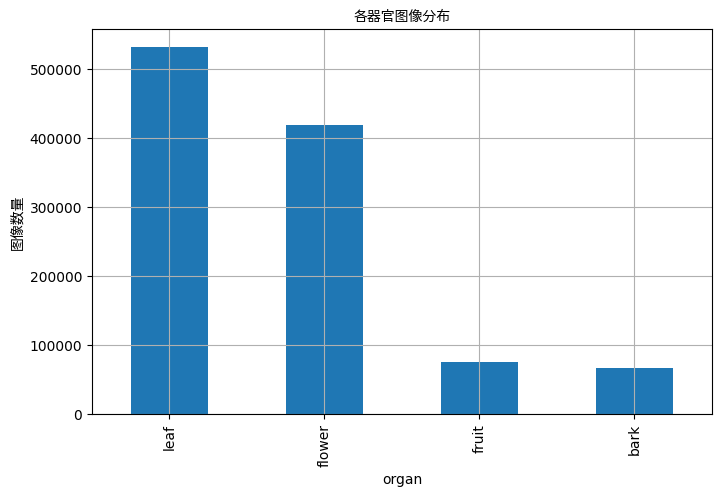

In [48]:
# 统计各器官图像数量
organ_counts = df_all['organ'].value_counts()

# 条形图显示
plt.figure(figsize=(8, 5))
organ_counts.plot(kind='bar')
plt.ylabel("图像数量", fontproperties=my_font)
plt.title("各器官图像分布", fontproperties=my_font)
plt.grid(True)
plt.show()


### resnet-50-----------------------------train

In [7]:
#
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
class PlantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        #return image, row['organ_label'], row['species_id']
        label = int(row['species_id'])
        return image, label
        
dataset = PlantDataset(df_all, transform)
#loader = DataLoader(dataset, batch_size=32, shuffle=True)
print(dataset)





In [89]:
print(df_all['species_id'].value_counts().describe())
print(df_all['species_id'].nunique())

count    3467.000000
mean      314.239977
std       349.867180
min         1.000000
25%        12.000000
50%       115.000000
75%       622.000000
max      1000.000000
Name: count, dtype: float64
3467


In [64]:
df_all.head()

,label,organ,image_path,organ_id,species_id,species_id_masked
0,Spathoglottis pubescens,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Sp...,1,3058,3058
1,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
2,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
3,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
4,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428


In [8]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [9]:
model = resnet50(pretrained=True)

#num_classes = len(species_classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

#model.fc = nn.Linear(model.fc.in_features, len(species_classes))  # 修改输出层

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)  # ✅ 将模型放到 CUDA 上

/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
print("✅ 标签最小值：", df_all['species_id'].min())
print("✅ 标签最大值：", df_all['species_id'].max())
print("✅ 类别总数（模型输出）：", len(species_classes))


✅ 标签最小值： 0
✅ 标签最大值： 3466
✅ 类别总数（模型输出）： 3467


In [11]:

# ✅ 1. 初始化
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 2

for epoch in range(num_epochs):
    # ✅ 2. 训练阶段
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}")
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix(loss=loss.item(), acc=correct/total)

    avg_train_loss = train_loss / total
    train_acc = correct / total

    # ✅ 3. 验证阶段
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_pbar = tqdm(val_loader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}")
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_pbar.set_postfix(loss=loss.item(), acc=correct/total)

    avg_val_loss = val_loss / total
    val_acc = correct / total

    print(f"✅ Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


[Train] Epoch 1/2:   0%|                     | 91/27237 [03:15<16:12:46,  2.15s/it, acc=0.000687, loss=8.06]


KeyboardInterrupt: 

## 大模型尝试

In [ ]:
#pip install open_clip_torch faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 737.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 9.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3━━━━━  0/10 [sympy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [open_clip_torch] [open_clip_torch]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import json

csv_path = "/mnt/e/code/plants-classification-conda/plant_multitask_dataset.csv"
species_json = "/mnt/e/code/plants-classification-conda/species_classes.json"

# 加载数据与类别映射
df_all = pd.read_csv(csv_path)
with open(species_json, "r", encoding="utf-8") as f:
    species_classes = json.load(f)

# 反向映射：id -> name
id_to_species = {v: k for k, v in species_classes.items()}


In [6]:
df_all.head()

,label,organ,image_path,organ_id,species_id,species_id_masked
0,Spathoglottis pubescens,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Sp...,1,3058,3058
1,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
2,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
3,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
4,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428


In [2]:
import torch
import open_clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='laion2b_s34b_b79k'
)
model = model.to(device).eval()
tokenizer = open_clip.get_tokenizer('ViT-B-32')


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [7]:
from tqdm import tqdm
import numpy as np
import faiss

all_embeddings = []
all_labels = []

for idx, row in tqdm(df_all.iterrows(), total=len(df_all)):
    try:
        image = preprocess(Image.open(row["image_path"]).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        all_embeddings.append(image_features.cpu().numpy())
        all_labels.append(row["species_id"])
    except Exception as e:
        print(f"❌ 错误跳过 {row['image_path']}：{e}")
        continue

emb_array = np.vstack(all_embeddings).astype("float32")
label_array = np.array(all_labels)


100%|███████████████████████████████████████████████████████████| 1089470/1089470 [4:41:25<00:00, 64.52it/s]


In [8]:
import faiss

index = faiss.IndexFlatIP(emb_array.shape[1])  # 使用内积衡量相似度（向量已归一化）
index.add(emb_array)
print("✅ faiss 索引建立完成，向量数量：", index.ntotal)


✅ faiss 索引建立完成，向量数量： 1089470


In [9]:
def predict_species(image_path, topk=5):
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    image_features = image_features.cpu().numpy().astype("float32")

    D, I = index.search(image_features, topk)
    predictions = [(id_to_species[label_array[i]], float(D[0][j])) for j, i in enumerate(I[0])]
    return predictions


In [14]:
test_img = "/mnt/e/code/plants-classification-conda/test_leaf.png"
results = predict_species(test_img, topk=3)

print("🌿 推理结果 Top-3：")
for name, score in results:
    print(f"{name}  相似度：{score:.4f}")


🌿 推理结果 Top-3：
Viburnum opulus  相似度：0.8671
Liriodendron chinense  相似度：0.8638
Lonicera tatarica  相似度：0.8629


In [16]:
df.head()

,label,organ,image_path,organ_id,species_id,species_id_masked
0,Spathoglottis pubescens,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Sp...,1,3058,3058
1,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
2,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
3,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428
4,Phoenix loureiroi,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ph...,3,2428,2428


## 二阶段模型

In [21]:
print("样本器官示例:", df['organ'].unique())
print("organ_classes 键:", list(organ_classes.keys()))


样本器官示例: ['flower' 'leaf' 'bark' 'fruit']
organ_classes 键: ['0', '1', '2', '3']


/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 3: 100%|███████████████████████████████| 17023/17023 [2:39:44<00:00,  1.78it/s, acc=0.852, loss=0.411]


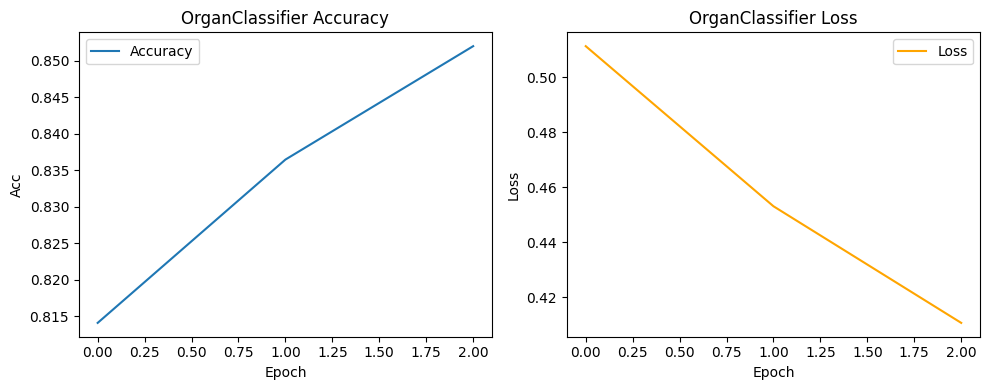

open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
Embedding bark:   3%|█▍                                                | 1955/65741 [00:49<27:46, 38.27it/s]

In [ ]:
# ✅ 两阶段植物识别系统：OrganClassifier + CLIP Species Retrieval
# 适用于 plant_multitask_dataset.csv 格式数据，字段包括 path, organ, label

import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ====== Step 1: 初始化设备与数据 ======
csv_path = "/mnt/e/code/plants-classification-conda/plant_multitask_dataset.csv"
organ_json = "/mnt/e/code/plants-classification-conda/organ_classes_20k.json"
species_json = "/mnt/e/code/plants-classification-conda/species_classes_full.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
df = pd.read_csv(csv_path)

with open(organ_json, 'r') as f:
    organ_classes = json.load(f)
organ_classes = {str(k).strip().lower(): v for k, v in organ_classes.items()}
    
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {v: k for k, v in species_classes.items()}
id_to_organ = {v: k for k, v in organ_classes.items()}

# ====== Step 2: 构建 OrganClassifier 数据集与模型 ======
class OrganDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        image = self.transform(image)
        #label_name = str(row['organ'])
        label_name = str(row['organ']).strip().lower()

        if label_name not in organ_classes:
            raise ValueError(f"未知的器官标签: {label_name}")
        label = organ_classes[label_name]
        return image, label

# 数据增强
organ_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
organ_dataset = OrganDataset(df, organ_transform)
organ_loader = DataLoader(organ_dataset, batch_size=64, shuffle=True)

# 构建模型
organ_model = models.resnet18(pretrained=True)
organ_model.fc = nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model = organ_model.to(device)

# 训练器官分类器（可加早停）
optimizer = torch.optim.Adam(organ_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

acc_list, loss_list = [], []
for epoch in range(3):  # 可调轮数
    organ_model.train()
    total, correct = 0, 0
    running_loss = 0
    loop = tqdm(organ_loader, desc=f"Epoch {epoch+1}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = organ_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)
        loop.set_postfix(acc=correct/total, loss=running_loss/total)
    acc_list.append(correct / total)
    loss_list.append(running_loss / total)

# 可视化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_list, label='Accuracy')
plt.title('OrganClassifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss_list, label='Loss', color='orange')
plt.title('OrganClassifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ====== Step 3: 构建每器官的 CLIP 向量库 ======
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clip_model = clip_model.to(device).eval()

organ_index = {}
organ_label_array = {}

for organ_name, organ_id in organ_classes.items():
    organ_df = df[df['organ'] == organ_name].reset_index(drop=True)
    embeddings = []
    labels = []
    for _, row in tqdm(organ_df.iterrows(), total=len(organ_df), desc=f"Embedding {organ_name}"):
        try:
            image = preprocess(Image.open(row['image_path']).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = clip_model.encode_image(image)
                emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.cpu().numpy())
            labels.append(species_classes[row['label']])
        except:
            continue
    if embeddings:
        emb_arr = np.vstack(embeddings).astype("float32")
        index = faiss.IndexFlatIP(emb_arr.shape[1])
        index.add(emb_arr)
        organ_index[organ_id] = index
        organ_label_array[organ_id] = np.array(labels)

# ====== Step 4: 两阶段推理函数 ======
def predict_species(image_path, topk=5):
    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    img_tensor = organ_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: CLIP 向量检索
    clip_img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, topk)
    result = [(id_to_species[labels[i]], float(D[0][j])) for j, i in enumerate(I[0])]
    return id_to_organ[pred_organ_id], result

# ====== Step 5: 测试 ======
img_path = "/mnt/e/code/plants-classification-conda/images/test_leaf.jpg"
organ_pred, top_preds = predict_species(img_path)
print("Predicted organ:", organ_pred)
for name, score in top_preds:
   print(f"{name}: {score:.4f}")


# 完全可用全流程模型


## 植物种类分类模型的预训练

In [3]:
import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [29]:
# 测试数据

# ✅ 两阶段植物识别系统：OrganClassifier + CLIP Species Retrieval
# 适用于 plant_multitask_dataset.csv 格式数据，字段包括 path, organ, label

import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ====== Step 1: 初始化设备与数据 ======
csv_path = "/mnt/e/code/plants-classification-conda/plant_num_top997.csv"
organ_json = "/mnt/e/code/plants-classification-conda/organ_classes_top997.json"
species_json = "/mnt/e/code/plants-classification-conda/species_classes_top997.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
df = pd.read_csv(csv_path)

with open(organ_json, 'r') as f:
    organ_classes = json.load(f)
organ_classes = {str(k).strip().lower(): v for k, v in organ_classes.items()}
    
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {v: k for k, v in species_classes.items()}
id_to_organ = {v: k for k, v in organ_classes.items()}

# ====== Step 2: 构建 OrganClassifier 数据集与模型 ======
class OrganDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        image = self.transform(image)
        #label_name = str(row['organ'])
        label_name = str(row['organ']).strip().lower()

        if label_name not in organ_classes:
            raise ValueError(f"未知的器官标签: {label_name}")
        label = organ_classes[label_name]
        return image, label

# 数据增强
organ_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
organ_dataset = OrganDataset(df, organ_transform)
organ_loader = DataLoader(organ_dataset, batch_size=64, shuffle=True)

# 构建模型
organ_model = models.resnet18(pretrained=True)
organ_model.fc = nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model = organ_model.to(device)

# 训练器官分类器（可加早停）
optimizer = torch.optim.Adam(organ_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

acc_list, loss_list = [], []
for epoch in range(3):  # 可调轮数
    organ_model.train()
    total, correct = 0, 0
    running_loss = 0
    loop = tqdm(organ_loader, desc=f"Epoch {epoch+1}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = organ_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)
        loop.set_postfix(acc=correct/total, loss=running_loss/total)
    acc_list.append(correct / total)
    loss_list.append(running_loss / total)

# 可视化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_list, label='Accuracy')
plt.title('OrganClassifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss_list, label='Loss', color='orange')
plt.title('OrganClassifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ====== Step 3: 构建每器官的 CLIP 向量库 ======
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clip_model = clip_model.to(device).eval()

organ_index = {}
organ_label_array = {}

for organ_name, organ_id in organ_classes.items():
    organ_df = df[df['organ'] == organ_name].reset_index(drop=True)
    embeddings = []
    labels = []
    for _, row in tqdm(organ_df.iterrows(), total=len(organ_df), desc=f"Embedding {organ_name}"):
        try:
            image = preprocess(Image.open(row['image_path']).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = clip_model.encode_image(image)
                emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.cpu().numpy())
            labels.append(species_classes[row['label']])
        except:
            continue
    if embeddings:
        emb_arr = np.vstack(embeddings).astype("float32")
        index = faiss.IndexFlatIP(emb_arr.shape[1])
        index.add(emb_arr)
        organ_index[organ_id] = index
        organ_label_array[organ_id] = np.array(labels)

# ====== Step 4: 两阶段推理函数 ======
'''def predict_species(image_path, topk=5):
    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    img_tensor = organ_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: CLIP 向量检索
    clip_img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, topk)
    result = [(id_to_species[labels[i]], float(D[0][j])) for j, i in enumerate(I[0])]
    return id_to_organ[pred_organ_id], result
'''


/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1:   7%|▋         | 27/390 [00:15<03:32,  1.71it/s, acc=0.649, loss=0.885]


KeyboardInterrupt: 

In [153]:
# ====== Step 5: 测试 ======
img_path = "/mnt/e/code/plants-classification-conda/test_leaf.png"
organ_pred, top_preds = predict_species(img_path)
print("Predicted organ:", organ_pred)
for name, score in top_preds:
   print(f"{name}: {score:.4f}")


Predicted organ: leaf
Berberis japonica: 0.7635
Berberis japonica: 0.7502
Acacia dealbata: 0.7442
Sambucus racemosa: 0.7390
Senecio vulgaris: 0.7363


In [154]:
#使用top997数据训练植物分类模型
#为了尽快测试功能1，2，3是否可行

#这一段是存储植物分类模型
torch.save(organ_model.state_dict(), "organ_classifier_top997.pth")

import faiss
import numpy as np
import os

os.makedirs("clip_index_top997", exist_ok=True)

for organ_id, index in organ_index.items():
    faiss.write_index(index, f"clip_index_top997/index_{organ_id}.index")
    np.save(f"clip_index_top997/labels_{organ_id}.npy", organ_label_array[organ_id])


with open("organ_classes_top997.json", "w") as f:
    json.dump(organ_classes, f)

with open("species_classes_top997.json", "w") as f:
    json.dump(species_classes, f)


In [4]:
#这一段是再关闭脚本之后的加载训练的植物模型的代码


import json
import torch
import faiss
import numpy as np
from torchvision import models, transforms
from PIL import Image
import open_clip
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ 1. 加载类别映射
with open("species_classes_top997.json") as f:
    species_classes = json.load(f)
with open("organ_classes_top997.json") as f:
    organ_classes = json.load(f)

id_to_species = {int(v): k for k, v in species_classes.items()}  # ✅ 保证key是int
id_to_organ = {int(v): k for k, v in organ_classes.items()}

# ✅ 2. 加载 organ_model
organ_model = models.resnet18(pretrained=False)
organ_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model.load_state_dict(torch.load("organ_classifier_top997.pth", map_location=device))
organ_model = organ_model.to(device).eval()


# 保存模型 state_dict

# ✅ 3. 加载 CLIP 模型
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
torch.save(clip_model.state_dict(), 'ViT-L-14.pt')
#clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained=None)
#clip_model.load_state_dict(torch.load('ViT-L-14.pt', map_location=device))
clip_model = clip_model.to(device).eval()

# ✅ 4. 加载 organ_transform
organ_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ 5. 加载 faiss index 和 labels
organ_index = {}
organ_label_array = {}
for organ_name, organ_id in organ_classes.items():
    index_path = f"clip_index_top997/index_{organ_id}.index"
    label_path = f"clip_index_top997/labels_{organ_id}.npy"
    if os.path.exists(index_path) and os.path.exists(label_path):
        organ_index[int(organ_id)] = faiss.read_index(index_path)
        organ_label_array[int(organ_id)] = np.load(label_path)
    else:
        print(f"❌ 缺失器官 {organ_name} 的索引或标签数组，跳过")


#只有植物种类分类的部分，可不运行
'''def predict_species(image_path, topk=5):
    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    img_tensor = organ_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: CLIP 检索
    clip_img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    # Step 3: 相似度检索
    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, topk)

    result = []
    for j, i in enumerate(I[0]):
        label_id = int(labels[i])  # ✅ 强制转换为 int
        species_name = id_to_species[label_id]  # ✅ 此时保证能查到
        result.append((species_name, float(D[0][j])))

    return id_to_organ[pred_organ_id], result'''


/tmp/ipykernel_31370/894423387.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  organ_model.load_state_dict(torch.load("organ_classifier_top997.pth", map_location=device

'def predict_species(image_path, topk=5):\n    # Step 1: 预测器官\n    image = Image.open(image_path).convert("RGB")\n    img_tensor = organ_transform(image).unsqueeze(0).to(device)\n    with torch.no_grad():\n        pred_organ_id = organ_model(img_tensor).argmax(1).item()\n\n    # Step 2: CLIP 检索\n    clip_img = preprocess(image).unsqueeze(0).to(device)\n    with torch.no_grad():\n        query_vec = clip_model.encode_image(clip_img)\n        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)\n        query_np = query_vec.cpu().numpy().astype("float32")\n\n    # Step 3: 相似度检索\n    index = organ_index[pred_organ_id]\n    labels = organ_label_array[pred_organ_id]\n    D, I = index.search(query_np, topk)\n\n    result = []\n    for j, i in enumerate(I[0]):\n        label_id = int(labels[i])  # ✅ 强制转换为 int\n        species_name = id_to_species[label_id]  # ✅ 此时保证能查到\n        result.append((species_name, float(D[0][j])))\n\n    return id_to_organ[pred_organ_id], result'

In [287]:
#重新加载后的测试

# ===== Step 8: 测试推理 =====
img_path = "/mnt/e/code/plants-classification-conda/test_bottel.png"  # 替换为你自己的图片路径

organ_name, top_results = predict_species(img_path)
#print("✅ 预测器官：", organ_name)
print("✅ Top5 植物预测结果：")
for name, score in top_results:
    print(f"  - {name}（相似度：{score:.4f}）")


✅ Top5 植物预测结果：
  - Sonchus arvensis（相似度：0.3032）
  - Rumex crispus（相似度：0.2862）
  - Acer rubrum（相似度：0.2860）
  - Malva sylvestris（相似度：0.2856）
  - Equisetum arvense（相似度：0.2828）


## 可以模型demo
### 使用openclip
##### 上面organ_classifier_pth模型保留，需要预训练+加载
##### 全流程使用plant_top997数据和相应映射，organ_classifier_pth模型已经存储，训练前需要调用
##### 以下是功能全流程（写在一个框内）：是否是植物、植物物种是否在我的数据集中、植物物种预测、病虫害判断、、
##### 可单张处理、可批处理（max=9）

In [5]:
import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
import hashlib
from torchvision import transforms, models
from torchvision.models import resnet18
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import collections

# ==== Step 0: 初始化路径与模型 ====
csv_path = "/mnt/e/code/plants-classification-conda/plant_num_top997.csv"
organ_json = "/mnt/e/code/plants-classification-conda/organ_classes_top997.json"
species_json = "/mnt/e/code/plants-classification-conda/species_classes_top997.json"
npz_path = "/mnt/e/code/plants-classification-conda/hashes_num_top997.npz"
#test_image = "/mnt/e/code/plants-classification-conda/test_leaf.png"

'''def resize_and_cache(df_csv, output_path, size=224):
    df = pd.read_csv(df_csv)
    images, labels, hashes = [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {output_path}"):
        img = cv2.imread(row['image_path'])
        if img is None:
            continue
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(row['species'])

        # 用于功能1：记录图像哈希值
        with open(row['image_path'], 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
            hashes.append(file_hash)

    images = np.stack(images)
    labels = np.array(labels)
    hashes = np.array(hashes)
    np.savez_compressed(output_path, images=images, labels=labels, hashes=hashes)
    print(f"✅ 缓存完成，共 {len(labels)} 张图像 -> {output_path}")

resize_and_cache(
    df_csv="/mnt/e/code/plants-classification-conda/plant_num_top997.csv",
    output_path="hashes_num_top997.npz",
    size=224
)'''

#df_filtered=pd.read_csv(csv_path)





'def resize_and_cache(df_csv, output_path, size=224):\n    df = pd.read_csv(df_csv)\n    images, labels, hashes = [], [], []\n    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {output_path}"):\n        img = cv2.imread(row[\'image_path\'])\n        if img is None:\n            continue\n        img = cv2.resize(img, (size, size))\n        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n        images.append(img)\n        labels.append(row[\'species\'])\n\n        # 用于功能1：记录图像哈希值\n        with open(row[\'image_path\'], \'rb\') as f:\n            file_hash = hashlib.md5(f.read()).hexdigest()\n            hashes.append(file_hash)\n\n    images = np.stack(images)\n    labels = np.array(labels)\n    hashes = np.array(hashes)\n    np.savez_compressed(output_path, images=images, labels=labels, hashes=hashes)\n    print(f"✅ 缓存完成，共 {len(labels)} 张图像 -> {output_path}")\n\nresize_and_cache(\n    df_csv="/mnt/e/code/plants-classification-conda/plant_num_top997.csv",\n    output_pa

In [6]:

# ==== Step 1: 加载数据与模型 ====
df = pd.read_csv(csv_path)
with open(organ_json, 'r') as f:
    organ_classes = json.load(f)
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {v: k for k, v in species_classes.items()}
id_to_organ = {v: k for k, v in organ_classes.items()}
organ_classes = {str(k).strip().lower(): v for k, v in organ_classes.items()}

# organ model
'''organ_model = resnet18(pretrained=True)
organ_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model.load_state_dict(torch.load("organ_classifier_top997.pth"))
organ_model.eval().cuda()

# CLIP model
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clip_model = clip_model.cuda().eval()

# 加载图像哈希   不需要用
#known_hashes = np.load(npz_path)['hashes']

# ==== Step 2: 构建 CLIP 检索索引 ====
organ_index, organ_label_array = {}, {}
for organ_name, organ_id in organ_classes.items():
    organ_df = df[df['organ'] == organ_name].reset_index(drop=True)
    embeddings, labels = [], []
    for _, row in tqdm(organ_df.iterrows(), total=len(organ_df), desc=f"Indexing {organ_name}"):
        try:
            image = preprocess(Image.open(row['image_path']).convert("RGB")).unsqueeze(0).cuda()
            with torch.no_grad():
                emb = clip_model.encode_image(image)
                emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.cpu().numpy())
            labels.append(species_classes[row['label']])
        except:
            continue
    if embeddings:
        emb_arr = np.vstack(embeddings).astype("float32")
        index = faiss.IndexFlatIP(emb_arr.shape[1])
        index.add(emb_arr)
        organ_index[organ_id] = index
        organ_label_array[organ_id] = np.array(labels)'''




'organ_model = resnet18(pretrained=True)\norgan_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))\norgan_model.load_state_dict(torch.load("organ_classifier_top997.pth"))\norgan_model.eval().cuda()\n\n# CLIP model\nclip_model, _, preprocess = open_clip.create_model_and_transforms(\'ViT-L-14\', pretrained=\'openai\')\nclip_model = clip_model.cuda().eval()\n\n# 加载图像哈希   不需要用\n#known_hashes = np.load(npz_path)[\'hashes\']\n\n# ==== Step 2: 构建 CLIP 检索索引 ====\norgan_index, organ_label_array = {}, {}\nfor organ_name, organ_id in organ_classes.items():\n    organ_df = df[df[\'organ\'] == organ_name].reset_index(drop=True)\n    embeddings, labels = [], []\n    for _, row in tqdm(organ_df.iterrows(), total=len(organ_df), desc=f"Indexing {organ_name}"):\n        try:\n            image = preprocess(Image.open(row[\'image_path\']).convert("RGB")).unsqueeze(0).cuda()\n            with torch.no_grad():\n                emb = clip_model.encode_image(image)\n                em

In [7]:
##============================= 功能1改进版----测试第一版 =========================####
## ==============   正确版本----------是否植物-------是否在我的数据中？？？？？？？？？？-------识别植物 =================


## ----------- 病虫害-----------病虫害线下大模型-----------------   for 节省token ================


# ====== Step 4: 两阶段推理函数 ======

# ====== 是否是植物======

#调整---------三---
def is_plant_clip(image_path):
    text_labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    with torch.no_grad():
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        text_tokens = open_clip.tokenize(text_labels).to(device)
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
    top_idx = logits.argmax().item()
    top_label = text_labels[top_idx]
    #print(f"🌱 是否植物判断：Top类 = {top_label}, 得分 = {logits[top_idx]:.4f}")
    return top_label == "a photo of a plant"
    score = logits[0].item()  # 植物标签得分
    #print("🌱 是否植物得分:", score)
    return score >= threshold


# ====== 是否是我数据库的植物=======
# ====== 植物预测=======

# 病虫害功能
def is_diseased_clip_from_images_voting(image_paths, vote_threshold=0.7):

    healthy_prompts = [
        "The leaves of healthy plants are usually bright green",
        "The leaves of healthy plants are usually full and shiny, with no obvious signs of disease or insect damage on the leaf surface",
        "Healthy plants usually have strong, straight stems that are able to support the weight of the plant",
        "Healthy plants will show vigorous growth, including sprouting new leaves, extending branches and blooming flowers",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "A healthy plant has bright flowers with intact petals and no wilting, falling off, or diseased spots"
        "The fruit of a healthy plant is full and has no cracks, rot or lesions. The fruit skin is normal color"
    ]
    diseased_prompts = [
        "Unhealthy plant leaves or flowers will have spots or patches of different shapes, sizes and colors, such as round, oval, polygonal, wheel-shaped",
        "Unhealthy plants have curled, shrunken, twisted leaves and flowers, and misshapen and stunted flowers",
        "Tumor-like protrusions appear on the stem, such as rose cancer, and swelling occurs",
        'Soft rot, wet rot or dry rot on the stem',
        "Unhealthy plants may have holes, nicks, or signs of being eaten on their leaves and petals",
        "Unhealthy plants may have visible insects, such as aphids and spider mites. Some pests will leave spider web-like silk",
        "Leaves lose their normal green color, show yellowing symptoms, partially or completely die, and appear brown or black",
        "The petals may appear water-soaked, rotten, softened, or even completely rotten."
    ]

    image_features_list = []
    for path in image_paths:
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).cuda()
            with torch.no_grad():
                feat = clip_model.encode_image(image)
                feat = feat / feat.norm(dim=-1, keepdim=True)
                image_features_list.append(feat)
        except Exception as e:
            print(f"❌ 图像处理失败: {path}, 错误: {e}")

    if not image_features_list:
        print("⚠️ 无有效图像特征，无法判断")
        return False

    # 平均图像特征
    image_features = torch.cat(image_features_list, dim=0).mean(dim=0, keepdim=True)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    diseased_votes = 0
    total_votes = 0

    with torch.no_grad():
        for h_prompt, d_prompt in zip(healthy_prompts, diseased_prompts):
            text_tokens = open_clip.tokenize([h_prompt, d_prompt]).cuda()
            text_features = clip_model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
            pred = logits.argmax().item()
            total_votes += 1
            if pred == 1:
                diseased_votes += 1

    ratio = diseased_votes / total_votes
    #print(f"🦠 病虫害投票结果（融合图像）: {diseased_votes}/{total_votes}（比例: {ratio:.2f}）")
    return ratio >= vote_threshold


#融合功能----主函数

def batch_predict_species_with_disease(image_paths, topk=5, sim_threshold=0.5, vote_threshold=0.7):
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    if not image_paths:
        print("❌ 输入图像列表为空")
        return

    max_batch = 9
    image_paths = image_paths[:max_batch]

    is_plant_flags = [is_plant_clip(p) for p in image_paths]
    num_plant = sum(is_plant_flags)
    print(f"🌿 共检测到 {num_plant}/{len(image_paths)} 张为植物图像")

    if num_plant <= len(image_paths) // 2:
        print("❌ 不是植物，无法识别")
        return

    predicted_species = []
    species_to_images = {}

    
#植物器官判定
#植物种类判断
    for i, is_plant in enumerate(is_plant_flags):
        if not is_plant:
            continue
        image_path = image_paths[i]
        try:
            image = Image.open(image_path).convert("RGB")
            img_tensor = organ_transform(image).unsqueeze(0).cuda()
            with torch.no_grad():
                pred_organ_id = organ_model(img_tensor).argmax(1).item()#器官预测：判断花叶果实

            clip_img = preprocess(image).unsqueeze(0).cuda()
            with torch.no_grad():
                # 提取图像特征（用于后续查找相似植物）
                query_vec = clip_model.encode_image(clip_img)
                query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
                query_np = query_vec.cpu().numpy().astype("float32")

            # 使用 Faiss 搜索最相似的植物种类（对应当前器官的索引库）
            index = organ_index[pred_organ_id]
            labels = organ_label_array[pred_organ_id]
            D, I = index.search(query_np, topk)

            # 获取 Top1 相似植物种类标签
            top_score = D[0][0]
            top_label = id_to_species[labels[I[0][0]]]

            if top_score >= sim_threshold:
                predicted_species.append(top_label)
                species_to_images.setdefault(top_label, []).append(image_path)
            else:
                predicted_species.append("unknown")


## 总体输出：for 单张 and 批量
## 融合判定
            # ✅ 单图模式下立即输出结果
            if len(image_paths) == 1:
                print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
                if top_score < sim_threshold:
                    print(f"⚠️ 相似度过低（最高得分 {top_score:.4f}），植物种类无法确认")
                    return
                else:
                    #print(f"🌿 识别为植物种类: {top_label}（得分: {top_score:.4f}）")

                    if top_score >= 0.8:
                        # ✅ 相似度高，输出 Top1
                        print(f"🌿 识别为植物种类: {top_label}（得分: {top_score:.4f}）")
                    else:
                        # ✅ 相似度一般，输出 Top3
                        print(f"⚠️ 相似度较低（最高得分 {top_score:.4f}），展示 Top3 候选:")
                        for j, i in enumerate(I[0][:3]):
                            species = id_to_species[labels[i]]
                            score = float(D[0][j])
                            print(f"🔸 候选 {j+1}: {species}（得分: {score:.4f}）")
                
                    has_disease = is_diseased_clip_from_images_voting([image_path], vote_threshold=vote_threshold)
                    print(f"🦠 病虫害判断: {'是' if has_disease else '否'}")
                    return

        except Exception as e:
            print(f"⚠️ 图像处理失败: {image_path}, 错误: {e}")
            predicted_species.append("unknown")

    known_species = [s for s in predicted_species if s != "unknown"]
    if len(image_paths) > 1 and len(known_species) <= len(predicted_species) // 2:
        print("⚠️ 大多数植物图像无法识别为数据集中已知物种")
        return

    counter = collections.Counter(known_species)
    top3 = counter.most_common(3)
    top1_species = top3[0][0]
    disease_image_paths = species_to_images.get(top1_species, [])
    has_disease = is_diseased_clip_from_images_voting(disease_image_paths, vote_threshold=vote_threshold)

    print("🌼 可能的植物是：")
    for name, count in top3:
        print(f"✅ {name}: {count}票")

    print(f"🦠 病虫害判断（Top1: {top1_species}）: {'是' if has_disease else '否'}（共 {len(disease_image_paths)} 张图像）")





In [8]:
#全流程测试
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula2.png"
batch_predict_species_with_disease(test_image)

🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: leaf
🌿 识别为植物种类: Populus tremula（得分: 0.8713）
🦠 病虫害判断: 否


In [35]:
test_image = "/mnt/e/code/plants-classification-conda/test_keyboard.png"
batch_predict_species_with_disease(test_image)

🌿 共检测到 0/1 张为植物图像
❌ 不是植物，无法识别


In [36]:
test_image = "/mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png"
batch_predict_species_with_disease(test_image)

🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: flower
🌿 识别为植物种类: Vitex agnus-castus（得分: 0.8675）
🦠 病虫害判断: 否


In [37]:
# 示例：支持 1~9 张图片
batch_predict_species_with_disease([
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula2.png",  
    "/mnt/e/code/plants-classification-conda/test_car.png",# 非植物
    "/mnt/e/code/plants-classification-conda/test_Rumex_crispus.jpg"
])


🌿 共检测到 4/5 张为植物图像
🌼 可能的植物是：
✅ Populus tremula: 3票
✅ Rumex crispus: 1票
🦠 病虫害判断（Top1: Populus tremula）: 否（共 3 张图像）


## 接口

In [47]:
model_loader_code = '''
import os
import json
import torch
import open_clip
import faiss
import numpy as np
from torchvision import models, transforms

WEIGHTS_DIR = "weights"
INDEX_DIR = os.path.join(WEIGHTS_DIR, "clip_index_top997")
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. 加载 organ_classes & species_classes
with open(os.path.join(WEIGHTS_DIR, "organ_classes_top997.json")) as f:
    organ_classes = json.load(f)
with open(os.path.join(WEIGHTS_DIR, "species_classes_top997.json")) as f:
    species_classes = json.load(f)
id_to_organ = {v: k for k, v in organ_classes.items()}
id_to_species = {v: k for k, v in species_classes.items()}

# 2. Organ 分类模型
organ_model = models.resnet18(pretrained=False)
organ_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model.load_state_dict(torch.load(os.path.join(WEIGHTS_DIR, "organ_classifier_top997.pth"), map_location=device))
organ_model = organ_model.to(device).eval()
organ_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 3. OpenCLIP
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-L-14", pretrained=None)
clip_model.load_state_dict(torch.load('weights/ViT-L-14.pt', map_location=device))
clip_model = clip_model.to(device).eval()

# 4. FAISS 向量索引和标签
organ_index = {}
organ_label_array = {}
for name, organ_id in organ_classes.items():
    index_path = os.path.join(INDEX_DIR, f"index_{organ_id}.index")
    label_path = os.path.join(INDEX_DIR, f"labels_{organ_id}.npy")
    if os.path.exists(index_path) and os.path.exists(label_path):
        organ_index[int(organ_id)] = faiss.read_index(index_path)
        organ_label_array[int(organ_id)] = np.load(label_path)
'''

with open("plant_api/model_loader.py", "w") as f:
    f.write(model_loader_code)

print("✅ 已生成兼容变量导出式 model_loader.py，可以直接和 inference/app 配套使用。")


✅ 已生成兼容变量导出式 model_loader.py，可以直接和 inference/app 配套使用。


In [52]:
inference_py_content = '''




import torch
import open_clip
import numpy as np
from PIL import Image
import collections
import requests
from io import BytesIO
import os
import uuid

from model_loader import (
    organ_model,
    organ_transform,
    clip_model,
    preprocess,
    organ_index,
    organ_label_array,
    id_to_organ,
    id_to_species
)


def download_image(url, temp_dir="uploads"):
    """下载网络图片并保存到临时文件"""
    try:
        print(f"🌐 正在下载: {url}")
        
        # 添加User-Agent避免被某些服务器拒绝
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(
            url, 
            timeout=30, 
            headers=headers, 
            allow_redirects=True,
            verify=True,  # SSL验证
            stream=True   # 流式下载，避免大文件占用内存
        )
        
        # 检查HTTP状态码
        if response.status_code != 200:
            print(f"❌ HTTP错误 {response.status_code}: {url}")
            if response.status_code == 404:
                print(f"   文件不存在: {url}")
            elif response.status_code == 403:
                print(f"   访问被拒绝: {url}")
            elif response.status_code == 500:
                print(f"   服务器内部错误: {url}")
            return None
        
        # 检查Content-Type
        content_type = response.headers.get('content-type', '').lower()
        if not any(img_type in content_type for img_type in ['image/', 'jpeg', 'png', 'gif', 'bmp']):
            print(f"❌ 非图片类型: {content_type}, URL: {url}")
            return None
        
        # 检查内容长度
        content_length = len(response.content)
        if content_length < 100:  # 太小可能是错误页面
            print(f"❌ 文件太小 ({content_length} bytes): {url}")
            return None
        
        print(f"✅ 下载成功 ({content_length} bytes)")
        
        # 创建临时目录
        os.makedirs(temp_dir, exist_ok=True)
        
        # 生成临时文件名
        file_ext = url.split('.')[-1].split('?')[0].lower()  # 处理URL参数
        if file_ext not in ['jpg', 'jpeg', 'png', 'gif', 'bmp']:
            file_ext = 'jpg'  # 默认扩展名
        
        temp_filename = f"{uuid.uuid4()}.{file_ext}"
        temp_path = os.path.join(temp_dir, temp_filename)
        
        # 验证是否为有效图片并保存
        try:
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.save(temp_path)
            print(f"💾 图片已保存: {temp_path}")
            return temp_path
        except Exception as img_error:
            print(f"❌ 图片格式错误: {img_error}")
            return None
            
    except requests.exceptions.SSLError as ssl_error:
        print(f"⚠️  SSL错误，尝试关闭SSL验证: {url}")
        try:
            # 尝试关闭SSL验证重新下载
            response = requests.get(
                url, 
                timeout=30, 
                headers=headers, 
                allow_redirects=True,
                verify=False,  # 关闭SSL验证
                stream=True
            )
            
            if response.status_code == 200:
                print(f"✅ SSL降级成功")
                content_length = len(response.content)
                if content_length < 100:
                    print(f"❌ 文件太小 ({content_length} bytes): {url}")
                    return None
                
                # 创建临时目录
                os.makedirs(temp_dir, exist_ok=True)
                
                # 生成临时文件名
                file_ext = url.split('.')[-1].split('?')[0].lower()
                if file_ext not in ['jpg', 'jpeg', 'png', 'gif', 'bmp']:
                    file_ext = 'jpg'
                
                temp_filename = f"{uuid.uuid4()}.{file_ext}"
                temp_path = os.path.join(temp_dir, temp_filename)
                
                # 验证并保存图片
                try:
                    img = Image.open(BytesIO(response.content)).convert("RGB")
                    img.save(temp_path)
                    print(f"💾 图片已保存: {temp_path}")
                    return temp_path
                except Exception as img_error:
                    print(f"❌ 图片格式错误: {img_error}")
                    return None
            else:
                print(f"❌ SSL降级后仍失败: {response.status_code}")
                return None
                
        except Exception as retry_error:
            print(f"❌ SSL降级失败: {retry_error}")
            return None
    except requests.exceptions.Timeout:
        print(f"❌ 下载超时: {url}")
        return None
    except requests.exceptions.ConnectionError:
        print(f"❌ 连接错误: {url}")
        return None
    except requests.exceptions.RequestException as e:
        print(f"❌ 请求错误: {e}, URL: {url}")
        return None
    except Exception as e:
        print(f"❌ 未知错误: {e}, URL: {url}")
        return None

def download_images_from_urls(urls, save_dir):
    downloaded = []
    failed = []
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    }
    for url in urls:
        try:
            file_ext = url.split("?")[0].split(".")[-1]
            filename = f"{uuid.uuid4()}.{file_ext}"
            save_path = os.path.join(save_dir, filename)

            r = requests.get(url, headers=headers, timeout=10, proxies={"http": None, "https": None})
            if r.status_code == 200:
                with open(save_path, "wb") as f:
                    f.write(r.content)
                downloaded.append(save_path)
            else:
                print(f"状态码异常：{r.status_code}")
                failed.append(url)
        except Exception as e:
            print(f"下载失败：{url}, 错误：{e}")
            failed.append(url)
    return downloaded, failed


def is_plant_clip(image_path):
    text_labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    with torch.no_grad():
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(next(clip_model.parameters()).device)
        text_tokens = open_clip.tokenize(text_labels).to(next(clip_model.parameters()).device)
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
    top_idx = logits.argmax().item()
    top_label = text_labels[top_idx]
    return top_label == "a photo of a plant"

def is_diseased_clip_from_images_voting(image_paths, vote_threshold=0.7):
    healthy_prompts = [
        "The leaves of healthy plants are usually bright green",
        "The leaves of healthy plants are usually full and shiny, with no obvious signs of disease or insect damage on the leaf surface",
        "Healthy plants usually have strong, straight stems that are able to support the weight of the plant",
        "Healthy plants will show vigorous growth, including sprouting new leaves, extending branches and blooming flowers",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "A healthy plant has bright flowers with intact petals and no wilting, falling off, or diseased spots",
        "The fruit of a healthy plant is full and has no cracks, rot or lesions. The fruit skin is normal color"
    ]
    diseased_prompts = [
        "Unhealthy plant leaves or flowers will have spots or patches of different shapes, sizes and colors, such as round, oval, polygonal, wheel-shaped",
        "Unhealthy plants have curled, shrunken, twisted leaves and flowers, and misshapen and stunted flowers",
        "Tumor-like protrusions appear on the stem, such as rose cancer, and swelling occurs",
        'Soft rot, wet rot or dry rot on the stem',
        "Unhealthy plants may have holes, nicks, or signs of being eaten on their leaves and petals",
        "Unhealthy plants may have visible insects, such as aphids and spider mites. Some pests will leave spider web-like silk",
        "Leaves lose their normal green color, show yellowing symptoms, partially or completely die, and appear brown or black",
        "The petals may appear water-soaked, rotten, softened, or even completely rotten."
    ]

    image_features_list = []
    for path in image_paths:
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(next(clip_model.parameters()).device)
            with torch.no_grad():
                feat = clip_model.encode_image(image)
                feat = feat / feat.norm(dim=-1, keepdim=True)
                image_features_list.append(feat)
        except Exception as e:
            print(f"❌ 图像处理失败: {path}, 错误: {e}")

    if not image_features_list:
        print("⚠️ 无有效图像特征，无法判断")
        return False

    image_features = torch.cat(image_features_list, dim=0).mean(dim=0, keepdim=True)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    diseased_votes = 0
    total_votes = 0

    with torch.no_grad():
        for h_prompt, d_prompt in zip(healthy_prompts, diseased_prompts):
            text_tokens = open_clip.tokenize([h_prompt, d_prompt]).to(next(clip_model.parameters()).device)
            text_features = clip_model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
            pred = logits.argmax().item()
            total_votes += 1
            if pred == 1:
                diseased_votes += 1

    ratio = diseased_votes / total_votes
    return bool(ratio >= vote_threshold)

def batch_predict_species_with_disease(image_paths, topk=3, sim_threshold=0.5, vote_threshold=0.7):
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    if not image_paths:
        return {
            "code": 400,
            "msg": "错误：输入图像列表为空",
            "data": {}
        }

    max_batch = 3
    image_paths = image_paths[:max_batch]

    is_plant_flags = [is_plant_clip(p) for p in image_paths]
    num_plant = sum(is_plant_flags)

    if num_plant <= len(image_paths) // 2:
        return {
            "code": 200,
            "msg": "成功",
            "data": {
                "is_plant": False,
                "is_database": False,
                "plants": [],
                "is_infected": False
            }
        }

    predicted_species = []
    species_to_images = {}
    species_to_scores = {}  # 新增：存储每个物种的相似度分数
    organ_results = []

    for i, is_plant in enumerate(is_plant_flags):
        if not is_plant:
            continue
        image_path = image_paths[i]
        try:
            image = Image.open(image_path).convert("RGB")
            img_tensor = organ_transform(image).unsqueeze(0).to(next(organ_model.parameters()).device)
            with torch.no_grad():
                pred_organ_id = organ_model(img_tensor).argmax(1).item()

            clip_img = preprocess(image).unsqueeze(0).to(next(clip_model.parameters()).device)
            with torch.no_grad():
                query_vec = clip_model.encode_image(clip_img)
                query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
                query_np = query_vec.cpu().numpy().astype("float32")

            index = organ_index[pred_organ_id]
            labels = organ_label_array[pred_organ_id]
            D, I = index.search(query_np, topk)

            top_score = D[0][0]
            top_label = id_to_species[labels[I[0][0]]]

            if top_score >= sim_threshold:
                predicted_species.append(top_label)
                species_to_images.setdefault(top_label, []).append(image_path)
                # 存储相似度分数
                if top_label not in species_to_scores:
                    species_to_scores[top_label] = []
                species_to_scores[top_label].append(float(top_score))
            else:
                predicted_species.append("unknown")

            organ_results.append(id_to_organ[pred_organ_id])

            if len(image_paths) == 1:
                if top_score < sim_threshold:
                    return {
                        "code": 200,
                        "msg": "成功",
                        "data": {
                            "is_plant": True,
                            "is_database": False,
                            "plants": [],
                            "is_infected": False
                        }
                    }
                else:
                    candidates = []
                    for j, idx in enumerate(I[0][:3]):
                        species = id_to_species[labels[idx]]
                        score = float(D[0][j])
                        candidates.append({
                            "latin_name": species,
                            "confidence": round(score, 4)
                        })
                    is_infected = is_diseased_clip_from_images_voting([image_path], vote_threshold=vote_threshold)
                    return {
                        "code": 200,
                        "msg": "成功",
                        "data": {
                            "is_plant": True,
                            "is_database": bool(top_score >= sim_threshold),
                            "plants": candidates,
                            "is_infected": bool(is_infected)
                        }
                    }
        except Exception as e:
            predicted_species.append("unknown")

    known_species = [s for s in predicted_species if s != "unknown"]
    if len(image_paths) > 1 and len(known_species) <= len(predicted_species) // 2:
        return {
            "code": 200,
            "msg": "成功",
            "data": {
                "is_plant": True,
                "is_database": False,
                "plants": [],
                "is_infected": False
            }
        }

    counter = collections.Counter(known_species)
    top3 = counter.most_common(3)
    top1_species = top3[0][0]
    disease_image_paths = species_to_images.get(top1_species, [])
    is_infected = is_diseased_clip_from_images_voting(disease_image_paths, vote_threshold=vote_threshold)

    # 构建plants列表，包含top3结果
    plants_list = []
    for name, votes in top3:
        # 使用实际相似度分数的平均值作为confidence
        if name in species_to_scores and species_to_scores[name]:
            avg_confidence = sum(species_to_scores[name]) / len(species_to_scores[name])
            confidence = round(avg_confidence, 4)
        else:
            # 如果没有分数记录，使用基于投票的估算
            confidence = round(votes / len(predicted_species) * 0.8, 4)
        
        plants_list.append({
            "latin_name": name,
            "confidence": confidence
        })

    return {
        "code": 200,
        "msg": "成功",
        "data": {
            "is_plant": True,
            "is_database": top1_species != "unknown",
            "plants": plants_list,
            "is_infected": bool(is_infected)
        }
    }

def predict_plant(image_path):
    return batch_predict_species_with_disease([image_path])







'''

with open("plant_api/inference.py", "w") as f:
    f.write(inference_py_content)

print("✅ 已生成完整 inference.py")


✅ 已生成完整 inference.py


In [49]:
app_py_content = '''

from fastapi import FastAPI, Form
from fastapi.responses import JSONResponse
from typing import List
from pydantic import BaseModel, Field
import os

from inference import predict_plant, batch_predict_species_with_disease, download_image

app = FastAPI(
    title="植物识别API",
    description="支持远程图片URL的植物识别服务，提供Form和JSON两种输入方式",
    version="1.0.0"
)

UPLOAD_DIR = "uploads"
os.makedirs(UPLOAD_DIR, exist_ok=True)


# Pydantic模型定义 - JSON格式
class URLRequest(BaseModel):
    image_urls: List[str] = Field(
        ..., 
        min_items=1, 
        max_items=10,
        description="图片URL列表，最多10个",
        example=[
            "https://httpbin.org/image/jpeg",
            "https://httpbin.org/image/png"
        ]
    )


@app.post("/predict/")
async def predict_from_urls_json(request: URLRequest):
    """
    通过远程图片URL进行植物识别 (JSON格式)
    
    支持：
    - 单个或多个URL（最多10个）
    - JSON格式输入
    - 自动下载图片并进行识别
    - 返回植物种类、置信度等信息
    """
    image_urls = request.image_urls
    
    downloaded_paths = []
    failed_urls = []
    
    try:
        # 下载图片
        for url in image_urls:
            result = download_image(url, UPLOAD_DIR)
            if result:
                downloaded_paths.append(result)
            else:
                failed_urls.append(url)
        
        if not downloaded_paths:
            return JSONResponse(
                content={
                    "code": 400,
                    "msg": f"错误：所有图片下载失败。失败的URL: {failed_urls}",
                    "data": {}
                }
            )
        
        # 进行预测
        if len(downloaded_paths) == 1:
            result = predict_plant(downloaded_paths[0])
        else:
            result = batch_predict_species_with_disease(downloaded_paths)
        
        # 在结果中添加下载信息
        if failed_urls:
            if "msg" in result:
                result["msg"] += f"（注意：{len(failed_urls)}个URL下载失败）"
        
        # 清理临时文件
        for file_path in downloaded_paths:
            if os.path.exists(file_path):
                os.remove(file_path)
                
        return JSONResponse(content=result)

    except Exception as e:
        # 清理临时文件
        for file_path in downloaded_paths:
            if os.path.exists(file_path):
                os.remove(file_path)
        
        return JSONResponse(
            status_code=500, 
            content={
                "code": 500,
                "msg": f"服务器错误：{str(e)}",
                "data": {}
            }
        )


@app.post("/predict_form/")
async def predict_from_urls_form(image_urls: List[str] = Form(..., description="图片URL列表，每行一个URL，最多10个")):
    """
    通过远程图片URL进行植物识别 (Form格式，SwaggerUI友好)
    
    支持：
    - 单个或多个URL（最多10个）  
    - Form表单格式输入
    - 在SwaggerUI中显示为表单字段
    - 自动下载图片并进行识别
    - 返回植物种类、置信度等信息
    """
    
    # 处理可能的多种输入格式
    processed_urls = []
    for url_item in image_urls:
        # 处理可能包含多个URL的字符串（逗号分隔）
        if ',' in url_item:
            urls = [u.strip() for u in url_item.split(',') if u.strip()]
            processed_urls.extend(urls)
        # 处理换行符分隔的URL
        elif '\\n' in url_item:
            urls = [u.strip() for u in url_item.split('\\n') if u.strip()]
            processed_urls.extend(urls)
        else:
            processed_urls.append(url_item.strip())
    
    # 去重并限制数量
    processed_urls = list(dict.fromkeys(processed_urls))  # 去重保持顺序
    if len(processed_urls) > 10:
        return JSONResponse(
            content={
                "code": 400,
                "msg": "错误：图片URL数量不能超过10个",
                "data": {}
            }
        )
    
    if not processed_urls:
        return JSONResponse(
            content={
                "code": 400,
                "msg": "错误：未提供任何有效的图片URL",
                "data": {}
            }
        )
    
    downloaded_paths = []
    failed_urls = []
    
    try:
        # 下载图片
        for url in processed_urls:
            result = download_image(url, UPLOAD_DIR)
            if result:
                downloaded_paths.append(result)
            else:
                failed_urls.append(url)
        
        if not downloaded_paths:
            return JSONResponse(
                content={
                    "code": 400,
                    "msg": f"错误：所有图片下载失败。失败的URL: {failed_urls}",
                    "data": {}
                }
            )
        
        # 进行预测
        if len(downloaded_paths) == 1:
            result = predict_plant(downloaded_paths[0])
        else:
            result = batch_predict_species_with_disease(downloaded_paths)
        
        # 在结果中添加下载信息
        if failed_urls:
            if "msg" in result:
                result["msg"] += f"（注意：{len(failed_urls)}个URL下载失败）"
        
        # 清理临时文件
        for file_path in downloaded_paths:
            if os.path.exists(file_path):
                os.remove(file_path)
                
        return JSONResponse(content=result)

    except Exception as e:
        # 清理临时文件
        for file_path in downloaded_paths:
            if os.path.exists(file_path):
                os.remove(file_path)
        
        return JSONResponse(
            status_code=500, 
            content={
                "code": 500,
                "msg": f"服务器错误：{str(e)}",
                "data": {}
            }
        )

'''

# Write app.py to the plant_api directory
with open("plant_api/app.py", "w") as f:
    f.write(app_py_content)

"✅ app.py 文件已生成，适配推理接口"

'✅ app.py 文件已生成，适配推理接口'

In [50]:
# 生成 requirements.txt 内容
requirements_txt_content = '''
fastapi==0.110.0
uvicorn[standard]==0.29.0
torch==2.1.0
torchvision==0.16.0
open_clip_torch==2.23.0
faiss-cpu==1.7.4
pillow==10.2.0
numpy==1.26.4
tqdm==4.66.2
python-multipart
'''

# 写入 plant_api/requirements.txt
with open("plant_api/requirements.txt", "w") as f:
    f.write(requirements_txt_content)

"✅ requirements.txt 文件已成功生成"


'✅ requirements.txt 文件已成功生成'

In [51]:
dockerfile_content = '''
FROM pytorch/pytorch:2.1.0-cuda11.8-cudnn8-runtime

WORKDIR /app
COPY . /app

ENV HTTP_PROXY=http://192.168.5.100:7890
ENV HTTPS_PROXY=http://192.168.5.100:7890
ENV http_proxy=http://192.168.5.100:7890
ENV https_proxy=http://192.168.5.100:7890
ENV NO_PROXY=localhost,127.0.0.1
ENV no_proxy=localhost,127.0.0.1


RUN pip install --upgrade pip && pip install -r requirements.txt

RUN mkdir -p uploads

EXPOSE 8000

CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000", "--reload"]

'''

with open("plant_api/Dockerfile", "w") as f:
    f.write(dockerfile_content)

print("✅ Dockerfile 合并指令已写入。请重新 docker build -t plant-api .")


✅ Dockerfile 合并指令已写入。请重新 docker build -t plant-api .


# 各种模型的测试与训练方案（不可用）

### 增加功能的调试过程
#### 识别是否在我的数据库中
#### 是否是植物
#### 病虫害检测


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载数据映射与 DataFrame
df_filtered = pd.read_csv("/mnt/e/code/plants-classification-conda/plant_num_top997.csv")

with open("/mnt/e/code/plants-classification-conda/organ_classes_top997.json", "r", encoding="utf-8") as f:
    organ_classes = json.load(f)
with open("/mnt/e/code/plants-classification-conda/species_classes_top997.json", "r", encoding="utf-8") as f:
    species_classes = json.load(f)

id_to_species = {v: k for k, v in species_classes.items()}
id_to_organ = {v: k for k, v in organ_classes.items()}

# 加载缓存图像
def load_npz_cache(path):
    data = np.load(path)
    return data['images'], data['labels']


#train_images, train_labels = load_npz_cache("train_cache.npz")
#val_images, val_labels = load_npz_cache("val_cache.npz")


In [10]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch

class CachedPlantDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = self.transform(img)
        return img, label


In [11]:
from torch.utils.data import DataLoader

train_dataset = CachedPlantDataset(train_images, train_labels)
val_dataset = CachedPlantDataset(val_images, val_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)


In [14]:
###！！！！！！！！！！！！！完全不可用！！！！！！


# prepare_cache.py
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
import hashlib

def resize_and_cache(df_csv, output_path, size=224):
    df = pd.read_csv(df_csv)
    images, labels, hashes = [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {output_path}"):
        img = cv2.imread(row['image_path'])
        if img is None:
            continue
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(row['species'])

        # 用于功能1：记录图像哈希值
        with open(row['image_path'], 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
            hashes.append(file_hash)

    images = np.stack(images)
    labels = np.array(labels)
    hashes = np.array(hashes)
    np.savez_compressed(output_path, images=images, labels=labels, hashes=hashes)
    print(f"✅ Saved to {output_path}. Total: {len(labels)} samples")

'''if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--csv", type=str, required=True, help="CSV file with columns: image_path,species")
    parser.add_argument("--output", type=str, required=True, help="Output .npz filename")
    parser.add_argument("--size", type=int, default=224, help="Resize image to (size, size)")
    args = parser.parse_args()

    resize_and_cache(args.csv, args.output, args.size)'''

resize_and_cache(csv_path, output_path_train, size=224)

# infer.py（整合Organ+CLIP+功能1+功能2+是否为植物识别）
import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
import argparse
import hashlib
import requests
from torchvision import transforms, models
from torchvision.models import resnet18
from torchvision.models._utils import IntermediateLayerGetter

def load_clip_and_index(csv_path, organ_json, species_json):
    df = pd.read_csv(csv_path)
    with open(organ_json, 'r') as f:
        organ_classes = json.load(f)
    organ_classes = {str(k).strip().lower(): v for k, v in organ_classes.items()}
    with open(species_json, 'r') as f:
        species_classes = json.load(f)
    id_to_species = {v: k for k, v in species_classes.items()}
    id_to_organ = {v: k for k, v in organ_classes.items()}

    organ_model = resnet18(pretrained=True)
    organ_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))
    organ_model.load_state_dict(torch.load("organ_model.pth"))
    organ_model.eval().cuda()

    clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
    clip_model = clip_model.cuda().eval()

    organ_index, organ_label_array = {}, {}
    for organ_name, organ_id in organ_classes.items():
        organ_df = df[df['organ'] == organ_name].reset_index(drop=True)
        embeddings, labels = [], []
        for _, row in organ_df.iterrows():
            try:
                image = preprocess(Image.open(row['image_path']).convert("RGB")).unsqueeze(0).cuda(non_blocking=True)
                with torch.no_grad():
                    emb = clip_model.encode_image(image)
                    emb = emb / emb.norm(dim=-1, keepdim=True)
                embeddings.append(emb.cpu().numpy())
                labels.append(species_classes[row['label']])
            except:
                continue
        if embeddings:
            emb_arr = np.vstack(embeddings).astype("float32")
            index = faiss.IndexFlatIP(emb_arr.shape[1])
            index.add(emb_arr)
            organ_index[organ_id] = index
            organ_label_array[organ_id] = np.array(labels)

    return organ_model, clip_model, preprocess, organ_index, organ_label_array, organ_classes, id_to_organ, id_to_species

def is_plant_image(image_path, threshold=0.3):
    api_url = "https://api-inference.huggingface.co/models/google/vit-base-patch16-224"
    headers = {"Authorization": "Bearer hf_your_token_here"}
    with open(image_path, 'rb') as f:
        img_bytes = f.read()
    response = requests.post(api_url, headers=headers, files={"file": img_bytes})
    try:
        result = response.json()
        for item in result:
            if 'plant' in item['label'].lower() and item['score'] >= threshold:
                return True
        return False
    except:
        return False

def predict_species(image_path, known_hashes, organ_model, clip_model, preprocess, organ_index, organ_label_array, organ_classes, id_to_organ, id_to_species):
    # 是否为植物判断
    if not is_plant_image(image_path):
        print("❌ 不是植物，请重新上传")
        return None

    # 功能1：是否在数据库
    with open(image_path, 'rb') as f:
        img_bytes = f.read()
        img_hash = hashlib.md5(img_bytes).hexdigest()
    if img_hash not in known_hashes:
        print("⚠️ 图像未在数据库中，无法识别")
        return None

    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img_tensor = transform(image).unsqueeze(0).cuda(non_blocking=True)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: CLIP 向量检索
    clip_img = preprocess(image).unsqueeze(0).cuda(non_blocking=True)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, 5)
    result = [(id_to_species[labels[i]], float(D[0][j])) for j, i in enumerate(I[0])]
    return id_to_organ[pred_organ_id], result, img_bytes

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--image", required=True, help="Path to image")
    parser.add_argument("--csv", required=True)
    parser.add_argument("--npz", required=True)
    parser.add_argument("--organ-json", required=True)
    parser.add_argument("--species-json", required=True)
    parser.add_argument("--disease-check", action='store_true')
    args = parser.parse_args()

    npz_data = np.load(args.npz)
    known_hashes = npz_data['hashes']

    organ_model, clip_model, preprocess, organ_index, organ_label_array, organ_classes, id_to_organ, id_to_species = load_clip_and_index(
        args.csv, args.organ_json, args.species_json
    )

    result = predict_species(
        args.image, known_hashes, organ_model, clip_model, preprocess,
        organ_index, organ_label_array, organ_classes, id_to_organ, id_to_species
    )

    if result:
        organ, preds, img_bytes = result
        print("🔍 器官类别:", organ)
        for name, score in preds:
            print(f"{name}: {score:.4f}")

        # 功能2：病虫害识别
        '''if args.disease_check:
            print("🌿 正在识别病虫害...")
            headers = {"Authorization": "Bearer hf_your_token_here"}  # 替换为真实 Token
            api_url = "https://api-inference.huggingface.co/models/nateraw/resnet50-plant-disease"
            response = requests.post(api_url, headers=headers, files={"file": img_bytes})
            try:
                result = response.json()
                if isinstance(result, list):
                    top = result[0]
                    print(f"🧬 病虫害诊断：{top['label']}，置信度：{top['score']:.4f}")
                else:
                    print(f"⚠️ 模型返回异常：{result}")
            except Exception as e:
                print(f"⚠️ 请求失败：{e}")'''


NameError: name 'output_path_train' is not defined

### 上文中需要的数据加载部分
#### 可能resnet50模型也使用在部分数据加载

In [3]:
import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
import hashlib
from torchvision import transforms, models
from torchvision.models import resnet18
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

# ==== Step 0: 初始化路径与模型 ====
csv_path = "/mnt/e/code/plants-classification-conda/plant_num_top997.csv"
organ_json = "/mnt/e/code/plants-classification-conda/organ_classes_top997.json"
species_json = "/mnt/e/code/plants-classification-conda/species_classes_top997.json"
npz_path = "/mnt/e/code/plants-classification-conda/hashes_num_top997.npz"
#test_image = "/mnt/e/code/plants-classification-conda/test_leaf.png"

def resize_and_cache(df_csv, output_path, size=224):
    df = pd.read_csv(df_csv)
    images, labels, hashes = [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {output_path}"):
        img = cv2.imread(row['image_path'])
        if img is None:
            continue
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(row['species'])

        # 用于功能1：记录图像哈希值
        with open(row['image_path'], 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
            hashes.append(file_hash)

    images = np.stack(images)
    labels = np.array(labels)
    hashes = np.array(hashes)
    np.savez_compressed(output_path, images=images, labels=labels, hashes=hashes)
    print(f"✅ 缓存完成，共 {len(labels)} 张图像 -> {output_path}")

resize_and_cache(
    df_csv="/mnt/e/code/plants-classification-conda/plant_num_top997.csv",
    output_path="hashes_num_top997.npz",
    size=224
)

#df_filtered=pd.read_csv(csv_path)





Processing hashes_num_top997.npz: 100%|██████████████████████████████| 24944/24944 [01:57<00:00, 211.91it/s]


✅ 缓存完成，共 24944 张图像 -> hashes_num_top997.npz


In [5]:

# ==== Step 1: 加载数据与模型 ====
df = pd.read_csv(csv_path)
with open(organ_json, 'r') as f:
    organ_classes = json.load(f)
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {v: k for k, v in species_classes.items()}
id_to_organ = {v: k for k, v in organ_classes.items()}
organ_classes = {str(k).strip().lower(): v for k, v in organ_classes.items()}

# organ model
organ_model = resnet18(pretrained=True)
organ_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model.load_state_dict(torch.load("organ_classifier_top997.pth"))
organ_model.eval().cuda()

# CLIP model
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clip_model = clip_model.cuda().eval()

# 加载图像哈希
known_hashes = np.load(npz_path)['hashes']

# ==== Step 2: 构建 CLIP 检索索引 ====
organ_index, organ_label_array = {}, {}
for organ_name, organ_id in organ_classes.items():
    organ_df = df[df['organ'] == organ_name].reset_index(drop=True)
    embeddings, labels = [], []
    for _, row in tqdm(organ_df.iterrows(), total=len(organ_df), desc=f"Indexing {organ_name}"):
        try:
            image = preprocess(Image.open(row['image_path']).convert("RGB")).unsqueeze(0).cuda()
            with torch.no_grad():
                emb = clip_model.encode_image(image)
                emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.cpu().numpy())
            labels.append(species_classes[row['label']])
        except:
            continue
    if embeddings:
        emb_arr = np.vstack(embeddings).astype("float32")
        index = faiss.IndexFlatIP(emb_arr.shape[1])
        index.add(emb_arr)
        organ_index[organ_id] = index
        organ_label_array[organ_id] = np.array(labels)




/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_13515/3255806944.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

In [6]:
### -------------------模型调试过程 --------
## 用于检验上两块的数据加载部分的可行性
## 数据加载部分！！@！通过检验！！！！！


# ==== Step 3: 是否是植物判断（CLIP Zero-Shot） ====
def is_plant_clip(image_path, threshold=0.3):
    text_labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    with torch.no_grad():
        #image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).cuda()
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        
        #text_tokens = open_clip.tokenize(text_labels).cuda()
        text_tokens = open_clip.tokenize(text_labels).to(device)
        
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
    score = logits[0].item()  # 植物标签得分
    print("🌱 是否植物得分:", score)
    return score >= threshold

# ==== Step 4: 主推理函数 ====
def predict_species(image_path):
    if not is_plant_clip(image_path):
        print("❌ 图像不是植物，请上传植物图像")
        return

    with open(image_path, 'rb') as f:
        img_hash = hashlib.md5(f.read()).hexdigest()
    if img_hash not in known_hashes:
        print("⚠️ 图像未在数据库中，无法识别")
        return

    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img_tensor = transform(image).unsqueeze(0).cuda()
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: 检索植物种类
    clip_img = preprocess(image).unsqueeze(0).cuda()
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, 5)
    result = [(id_to_species[labels[i]], float(D[0][j])) for j, i in enumerate(I[0])]

    print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
    for name, score in result:
        print(f"✅ {name}（得分: {score:.4f}）")


In [8]:
# ==== Step 5: 测试 ====
test_image = "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg"
predict_species(test_image)


🌱 是否植物得分: 0.5706782341003418
🔍 识别为器官: flower
✅ Populus tremula（得分: 1.0000）
✅ Populus tremula（得分: 0.8554）
✅ Acer negundo（得分: 0.8429）
✅ Populus tremula（得分: 0.8401）
✅ Acer negundo（得分: 0.8339）


In [12]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png"
predict_species(test_image)

🌱 是否植物得分: 0.9678565263748169
⚠️ 图像未在数据库中，无法识别


In [9]:
test_image = "/mnt/e/code/plants-classification-conda/test_leaf.png"
predict_species(test_image)


🌱 是否植物得分: 0.9465965628623962
⚠️ 图像未在数据库中，无法识别


In [10]:
test_image = "/mnt/e/code/plants-classification-conda/test_keyboard.png"
predict_species(test_image)

🌱 是否植物得分: 0.009094640612602234
❌ 图像不是植物，请上传植物图像


In [11]:
test_image = "/mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png"
predict_species(test_image)

🌱 是否植物得分: 0.9744583368301392
⚠️ 图像未在数据库中，无法识别


### 可用模型1的调试与优化部分：是否植物-是否在我数据中-植物判断
#### 用 clip检索+fassi 向量、相似度
##### 是否植物准确率约等于0.5-0.6（需调）； 是否在我数据中（一定误差）
##### 暂时已调整好，整合至上文
##### 但还需要调整 ！！！！植物种类的准确率需要提高，降低泛化误差

In [264]:
##============================= 功能1改进版----测试第一版 =========================####
## ==============   正确版本----------是否植物-------是否在我的数据中？？？？？？？？？？-------识别植物 =================


## ----------- 病虫害-----------病虫害线下大模型-----------------   for 节省token ================


# ====== Step 4: 两阶段推理函数 ======

# ====== 是否是植物======
'''def is_plant_clip(image_path, threshold=0.4):
    text_labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    with torch.no_grad():
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        text_tokens = open_clip.tokenize(text_labels).to(device)
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
    score = logits[0].item()  # 植物标签得分
    print("🌱 是否植物得分:", score)
    return score >= threshold'''

'''def is_plant_clip(image_path):
    text_labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    with torch.no_grad():
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        text_tokens = open_clip.tokenize(text_labels).to(device)
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
    
    top_idx = logits.argmax().item()
    print(f"🌱 是否植物判断：Top类 = {text_labels[top_idx]}, 得分 = {logits[top_idx]:.4f}")
    return top_idx == 0  # 0 对应 "a photo of a plant"'''

#调整---------三---
def is_plant_clip(image_path):
    text_labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    with torch.no_grad():
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        text_tokens = open_clip.tokenize(text_labels).to(device)
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
    top_idx = logits.argmax().item()
    top_label = text_labels[top_idx]
    print(f"🌱 是否植物判断：Top类 = {top_label}, 得分 = {logits[top_idx]:.4f}")
    return top_label == "a photo of a plant"
    score = logits[0].item()  # 植物标签得分
    print("🌱 是否植物得分:", score)
    return score >= threshold


# ====== 是否是我数据库的植物=======
# ====== 植物预测=======
'''def predict_species(image_path, sim_threshold=0.25, topk=5):
    if not is_plant_clip(image_path):
        print("❌ 图像不是植物，请上传植物图像")
        return

    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    img_tensor = organ_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: CLIP 特征向量
    clip_img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    # Step 3: 最近邻搜索
    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, topk)
    top_score = D[0][0]

    #print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
    if top_score < sim_threshold:
        print(f"⚠️ 相似度过低（最高得分 {top_score:.4f}），植物种类无法确认")
    else:
        for j, i in enumerate(I[0]):
            species = id_to_species[labels[i]]
            score = float(D[0][j])
            print(f"✅ {species}（得分: {score:.4f}）")'''

'''def predict_species(image_path, sim_threshold=0.2, topk=5):
    if not is_plant_clip(image_path):
        print("❌ 图像不是植物，请上传植物图像")
        return

    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    img_tensor = organ_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: CLIP 特征向量
    clip_img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    # Step 3: 最近邻搜索
    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, topk)
    top_score = D[0][0]
    top_label = id_to_species[labels[I[0][0]]]

    print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")

    if top_score < sim_threshold:
        print(f"⚠️ 相似度过低（最高得分 {top_score:.4f}），植物种类无法确认")
    else:
        print(f"🌿 识别为植物种类: {top_label}（得分: {top_score:.4f}）")
        for j, i in enumerate(I[0]):
            species = id_to_species[labels[i]]
            score = float(D[0][j])
            print(f"✅ {species}（得分: {score:.4f}）")'''




#------------需要引入 拒识机制（Rejection）--------------
#------------ 判断是否在我的数据集中--------

'''    # Step 3: 最近邻搜索
    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, topk)

    top1_score = float(D[0][0])
    top2_score = float(D[0][1])
    gap_score = top1_score - top2_score

    print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
    print(f"Top-1 相似度: {top1_score:.4f}, Top-2 相似度: {top2_score:.4f}, 差值: {gap_score:.4f}")

    # Rejection 判断逻辑
    if top1_score < sim_threshold or gap_score < 0.0019:
        print(f"⚠️ 无法确认植物种类：可能不在数据库中")
        return
    else:
        top_label = id_to_species[labels[I[0][0]]]
        print(f"🌿 识别为植物种类: {top_label}（得分: {top1_score:.4f}）")
        for j, i in enumerate(I[0]):
            species = id_to_species[labels[i]]
            score = float(D[0][j])
            print(f"✅ {species}（得分: {score:.4f}）")'''



# 病虫害功能
def is_diseased_clip_from_images_voting(image_paths, vote_threshold=0.7):

    healthy_prompts = [
        "The leaves of healthy plants are usually bright green",
        "The leaves of healthy plants are usually full and shiny, with no obvious signs of disease or insect damage on the leaf surface",
        "Healthy plants usually have strong, straight stems that are able to support the weight of the plant",
        "Healthy plants will show vigorous growth, including sprouting new leaves, extending branches and blooming flowers",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "A healthy plant has bright flowers with intact petals and no wilting, falling off, or diseased spots"
        "The fruit of a healthy plant is full and has no cracks, rot or lesions. The fruit skin is normal color"
    ]
    diseased_prompts = [
        "Unhealthy plant leaves or flowers will have spots or patches of different shapes, sizes and colors, such as round, oval, polygonal, wheel-shaped",
        "Unhealthy plants have curled, shrunken, twisted leaves and flowers, and misshapen and stunted flowers",
        "Tumor-like protrusions appear on the stem, such as rose cancer, and swelling occurs",
        'Soft rot, wet rot or dry rot on the stem',
        "Unhealthy plants may have holes, nicks, or signs of being eaten on their leaves and petals",
        "Unhealthy plants may have visible insects, such as aphids and spider mites. Some pests will leave spider web-like silk",
        "Leaves lose their normal green color, show yellowing symptoms, partially or completely die, and appear brown or black",
        "The petals may appear water-soaked, rotten, softened, or even completely rotten."
    ]

    image_features_list = []
    for path in image_paths:
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).cuda()
            with torch.no_grad():
                feat = clip_model.encode_image(image)
                feat = feat / feat.norm(dim=-1, keepdim=True)
                image_features_list.append(feat)
        except Exception as e:
            print(f"❌ 图像处理失败: {path}, 错误: {e}")

    if not image_features_list:
        print("⚠️ 无有效图像特征，无法判断")
        return False

    # 平均图像特征
    image_features = torch.cat(image_features_list, dim=0).mean(dim=0, keepdim=True)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    diseased_votes = 0
    total_votes = 0

    with torch.no_grad():
        for h_prompt, d_prompt in zip(healthy_prompts, diseased_prompts):
            text_tokens = open_clip.tokenize([h_prompt, d_prompt]).cuda()
            text_features = clip_model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
            pred = logits.argmax().item()
            total_votes += 1
            if pred == 1:
                diseased_votes += 1

    ratio = diseased_votes / total_votes
    print(f"🦠 病虫害投票结果（融合图像）: {diseased_votes}/{total_votes}（比例: {ratio:.2f}）")
    return ratio >= vote_threshold


#融合功能----主函数

def batch_predict_species_with_disease(image_paths, topk=5, sim_threshold=0.5, vote_threshold=0.7):
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    if not image_paths:
        print("❌ 输入图像列表为空")
        return

    max_batch = 9
    image_paths = image_paths[:max_batch]

    is_plant_flags = [is_plant_clip(p) for p in image_paths]
    num_plant = sum(is_plant_flags)
    print(f"🌿 共检测到 {num_plant}/{len(image_paths)} 张为植物图像")

    if num_plant <= len(image_paths) // 2:
        print("❌ 大多数图像不是植物，无法识别")
        return

    predicted_species = []
    species_to_images = {}

    for i, is_plant in enumerate(is_plant_flags):
        if not is_plant:
            continue
        image_path = image_paths[i]
        try:
            image = Image.open(image_path).convert("RGB")
            img_tensor = organ_transform(image).unsqueeze(0).cuda()
            with torch.no_grad():
                pred_organ_id = organ_model(img_tensor).argmax(1).item()

            clip_img = preprocess(image).unsqueeze(0).cuda()
            with torch.no_grad():
                query_vec = clip_model.encode_image(clip_img)
                query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
                query_np = query_vec.cpu().numpy().astype("float32")

            index = organ_index[pred_organ_id]
            labels = organ_label_array[pred_organ_id]
            D, I = index.search(query_np, topk)

            top_score = D[0][0]
            top_label = id_to_species[labels[I[0][0]]]

            if top_score >= sim_threshold:
                predicted_species.append(top_label)
                species_to_images.setdefault(top_label, []).append(image_path)
            else:
                predicted_species.append("unknown")

            # ✅ 单图模式下立即输出结果
            if len(image_paths) == 1:
                print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
                if top_score < sim_threshold:
                    print(f"⚠️ 相似度过低（最高得分 {top_score:.4f}），植物种类无法确认")
                    return
                else:
                    print(f"🌿 识别为植物种类: {top_label}（得分: {top_score:.4f}）")
                    has_disease = is_diseased_clip_from_images_voting([image_path], vote_threshold=vote_threshold)
                    print(f"🦠 病虫害判断: {'是' if has_disease else '否'}")
                    return

        except Exception as e:
            print(f"⚠️ 图像处理失败: {image_path}, 错误: {e}")
            predicted_species.append("unknown")

    known_species = [s for s in predicted_species if s != "unknown"]
    if len(image_paths) > 1 and len(known_species) <= len(predicted_species) // 2:
        print("⚠️ 大多数植物图像无法识别为数据集中已知物种")
        return

    counter = collections.Counter(known_species)
    top3 = counter.most_common(3)
    top1_species = top3[0][0]
    disease_image_paths = species_to_images.get(top1_species, [])
    has_disease = is_diseased_clip_from_images_voting(disease_image_paths, vote_threshold=vote_threshold)

    print("🌼 投票结果：")
    for name, count in top3:
        print(f"✅ {name}: {count}票")

    print(f"🦠 病虫害判断（Top1: {top1_species}）: {'是' if has_disease else '否'}（共 {len(disease_image_paths)} 张图像）")





In [242]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg"
batch_predict_species_with_disease(test_image)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.5707
🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: flower
🌿 识别为植物种类: Populus tremula（得分: 1.0000）
🦠 病虫害投票结果（融合图像）: 6/7（比例: 0.86）
🦠 病虫害判断: 是


In [243]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png"
batch_predict_species_with_disease(test_image)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9679
🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: leaf
🌿 识别为植物种类: Populus tremula（得分: 0.8535）
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29）
🦠 病虫害判断: 否


In [244]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png"
batch_predict_species_with_disease(test_image)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.8060
🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: fruit
🌿 识别为植物种类: Populus tremula（得分: 0.8189）
🦠 病虫害投票结果（融合图像）: 4/7（比例: 0.57）
🦠 病虫害判断: 否


In [245]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula2.png"
batch_predict_species_with_disease(test_image)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9605
🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: leaf
🌿 识别为植物种类: Populus tremula（得分: 0.8713）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🦠 病虫害判断: 否


In [246]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula3.png"
batch_predict_species_with_disease(test_image)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9725
🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: leaf
🌿 识别为植物种类: Acer rubrum（得分: 0.8476）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🦠 病虫害判断: 否


In [247]:
test_image = "/mnt/e/code/plants-classification-conda/test_keyboard.png"
batch_predict_species_with_disease(test_image)

🌱 是否植物判断：Top类 = a photo of an object, 得分 = 0.8835
🌿 共检测到 0/1 张为植物图像
❌ 大多数图像不是植物，无法识别


In [248]:
test_image = "/mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png"
batch_predict_species_with_disease(test_image, sim_threshold=0.9)


🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9745
🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: flower
⚠️ 相似度过低（最高得分 0.8675），植物种类无法确认


In [249]:
test_image = "/mnt/e/code/plants-classification-conda/test_leaf.png"
batch_predict_species_with_disease(test_image, sim_threshold=0.9)


🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9466
🌿 共检测到 1/1 张为植物图像
🔍 识别为器官: leaf
⚠️ 相似度过低（最高得分 0.7635），植物种类无法确认


In [266]:
# 示例：支持 1~9 张图片
batch_predict_species_with_disease([
    "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png",  
    "/mnt/e/code/plants-classification-conda/test_keyboard.png",# 非植物
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula3.png"
])


🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.5707
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9679
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.8060
🌱 是否植物判断：Top类 = a photo of an object, 得分 = 0.8835
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9725
🌿 共检测到 4/5 张为植物图像
🦠 病虫害投票结果（融合图像）: 3/7（比例: 0.43）
🌼 投票结果：
✅ Populus tremula: 3票
✅ Acer rubrum: 1票
🦠 病虫害判断（Top1: Populus tremula）: 否（共 3 张图像）


In [98]:
## ----------增加多张图片功能 -----------

import collections
from typing import List

def batch_predict_species(image_paths: List[str], topk=5, sim_threshold=0.2):
    if not image_paths:
        print("❌ 输入图像列表为空")
        return

    max_batch = 9
    image_paths = image_paths[:max_batch]
    
    # 1. 判断哪些图片是植物
    is_plant_flags = [is_plant_clip(p) for p in image_paths]
    num_plant = sum(is_plant_flags)
    print(f"🌿 共检测到 {num_plant}/{len(image_paths)} 张为植物图像")

    if num_plant <= len(image_paths) // 2:
        print("❌ 大多数图像不是植物，无法识别")
        return

    # 2. 仅对是植物的图像进行识别
    predicted_species = []
    for i, is_plant in enumerate(is_plant_flags):
        if not is_plant:
            continue
        image_path = image_paths[i]
        try:
            # 器官分类
            image = Image.open(image_path).convert("RGB")
            img_tensor = organ_transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_organ_id = organ_model(img_tensor).argmax(1).item()

            # 特征提取 + 检索
            clip_img = preprocess(image).unsqueeze(0).to(device)
            with torch.no_grad():
                query_vec = clip_model.encode_image(clip_img)
                query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
                query_np = query_vec.cpu().numpy().astype("float32")

            index = organ_index[pred_organ_id]
            labels = organ_label_array[pred_organ_id]
            D, I = index.search(query_np, topk)

            # 只考虑得分高的第一名
            top_score = D[0][0]
            top_label = id_to_species[labels[I[0][0]]]

            if top_score >= sim_threshold:
                predicted_species.append(top_label)
            else:
                predicted_species.append("unknown")
        except Exception as e:
            print(f"⚠️ 图像处理失败: {image_path}, 错误: {e}")
            predicted_species.append("unknown")

    # 3. 判断是否大多数识别在数据集内
    known_species = [s for s in predicted_species if s != "unknown"]
    if len(known_species) <= len(predicted_species) // 3:
        print("⚠️ 大多数植物图像无法识别为数据集中已知物种")
        return

    # 4. 投票输出 Top3 物种
    counter = collections.Counter(known_species)
    top3 = counter.most_common(3)
    print("🌼 投票结果：")
    for name, count in top3:
        print(f"✅ {name}: {count}票")

    return top3


In [146]:
# 示例：支持 1~9 张图片
batch_predict_species([
    "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png",  
    "/mnt/e/code/plants-classification-conda/test_keyboard.png",# 非植物
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula3.png"
], sim_threshold=0.9)


🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.5707
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9679
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.8060
🌱 是否植物判断：Top类 = a photo of an object, 得分 = 0.8835
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9725
🌿 共检测到 4/5 张为植物图像
⚠️ 大多数植物图像无法识别为数据集中已知物种


In [198]:
## =========== 病虫害可用 ==================

def is_diseased_clip(image_path, diff_threshold=0.2):
    labels = [
        '''"a healthy plant with green leaves and no spots",
        "a plant with visible disease signs like spots, wilting or pests"'''
        "The leaves of healthy plants are usually bright green",
        "The leaves of healthy plants are usually full and shiny, with no obvious signs of disease or insect damage on the leaf surface",
        "Healthy plants usually have strong, straight stems that are able to support the weight of the plant",
        "Healthy plants will show vigorous growth, including sprouting new leaves, extending branches and blooming flowers",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "A healthy plant has bright flowers with intact petals and no wilting, falling off, or diseased spots"
        "The fruit of a healthy plant is full and has no cracks, rot or lesions. The fruit skin is normal color"
    ]
    with torch.no_grad():
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        text_tokens = open_clip.tokenize(labels).to(device)

        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()

    healthy_score = logits[0].item()
    disease_score = logits[1].item()
    diff = disease_score - healthy_score

    print(f"🦠 健康得分: {healthy_score:.4f} | 病虫害得分: {disease_score:.4f} | 差值: {diff:.4f}")

    return diff > diff_threshold  # 超过阈值才认定为病虫害


In [262]:
## =========== 病虫害可用预测主函数 ==================


# 修复后批量识别函数（始终执行病虫害判断）
def batch_predict_species_with_disease(image_paths: List[str], topk=5, sim_threshold=0.2):
    if not image_paths:
        print("❌ 输入图像列表为空")
        return

    max_batch = 9
    image_paths = image_paths[:max_batch]
    
    is_plant_flags = [is_plant_clip(p) for p in image_paths]
    num_plant = sum(is_plant_flags)
    print(f"🌿 共检测到 {num_plant}/{len(image_paths)} 张为植物图像")

    if num_plant <= len(image_paths) // 2:
        print("❌ 大多数图像不是植物，无法识别")
        return

    predicted_species = []
    disease_results = []
    species_to_images = {}

    for i, is_plant in enumerate(is_plant_flags):
        if not is_plant:
            continue
        image_path = image_paths[i]
        try:
            image = Image.open(image_path).convert("RGB")
            img_tensor = organ_transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_organ_id = organ_model(img_tensor).argmax(1).item()

            clip_img = preprocess(image).unsqueeze(0).to(device)
            with torch.no_grad():
                query_vec = clip_model.encode_image(clip_img)
                query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
                query_np = query_vec.cpu().numpy().astype("float32")

            index = organ_index[pred_organ_id]
            labels = organ_label_array[pred_organ_id]
            D, I = index.search(query_np, topk)

            top_score = D[0][0]
            top_label = id_to_species[labels[I[0][0]]]

            print(f"🎯 相似度得分: {top_score:.4f}")

            if top_score >= sim_threshold:
                predicted_species.append(top_label)
                species_to_images.setdefault(top_label, []).append(image_path)
            else:
                predicted_species.append("unknown")


        except Exception as e:
            print(f"⚠️ 图像处理失败: {image_path}, 错误: {e}")
            predicted_species.append("unknown")

    known_species = [s for s in predicted_species if s != "unknown"]
    if len(known_species) <= len(predicted_species) // 3:
        print("⚠️ 大多数植物图像无法识别为数据集中已知物种")
        return

    counter = collections.Counter(known_species)
    top3 = counter.most_common(3)
    # 🎯 选出出现次数最多的 top1 植物种类
    #top1_species = most_common(predicted_species)
    top1_species = top3[0][0]


    # 🦠 将该种类所有图像提取出来，做病虫害判断
    disease_image_paths = species_to_images.get(top1_species, [])

    disease_yes = 0
    for path in disease_image_paths:
        if is_diseased_clip(path):
            disease_yes += 1


    
    print("🌼 投票结果：")
    for name, count in top3:
        print(f"✅ {name}: {count}票")

    '''if disease_results:
        count_disease = disease_results.count("有病虫害")
        print(f"🦠 病虫害识别结果：{count_disease}/{len(disease_results)} 张图像检测到病虫害")

    return top3, disease_results'''

    #print(f"✅ Top1: {top1_species}（得票数: {len(disease_image_paths)}）")
    print(f"🦠 病虫害判断：{'是' if disease_yes > len(disease_image_paths) // 2 else '否'}（{disease_yes}/{len(disease_image_paths)} 张表现为病虫害）")

In [263]:
# 示例：支持 1~9 张图片
batch_predict_species_with_disease([
    "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png",  
    "/mnt/e/code/plants-classification-conda/test_keyboard.png",# 非植物
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula3.png"
], sim_threshold=0.85)


🌿 共检测到 4/5 张为植物图像
🎯 相似度得分: 1.0000
🎯 相似度得分: 0.8535
🎯 相似度得分: 0.8189
🎯 相似度得分: 0.8476
🦠 健康得分: 0.5380 | 病虫害得分: 0.0439 | 差值: -0.4941
🦠 健康得分: 0.2524 | 病虫害得分: 0.2019 | 差值: -0.0505
🌼 投票结果：
✅ Populus tremula: 2票
🦠 病虫害判断：否（0/2 张表现为病虫害）


In [165]:
test_image = "/mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png"
batch_predict_species_with_disease(test_image)

IsADirectoryError: [Errno 21] Is a directory: '/'

In [208]:
def is_diseased_clip_from_images_voting(image_paths, vote_threshold=0.7):

    healthy_prompts = [
        "The leaves of healthy plants are usually bright green",
        "The leaves of healthy plants are usually full and shiny, with no obvious signs of disease or insect damage on the leaf surface",
        "Healthy plants usually have strong, straight stems that are able to support the weight of the plant",
        "Healthy plants will show vigorous growth, including sprouting new leaves, extending branches and blooming flowers",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "A healthy plant has bright flowers with intact petals and no wilting, falling off, or diseased spots"
        "The fruit of a healthy plant is full and has no cracks, rot or lesions. The fruit skin is normal color"
    ]
    diseased_prompts = [
        "Unhealthy plant leaves or flowers will have spots or patches of different shapes, sizes and colors, such as round, oval, polygonal, wheel-shaped",
        "Unhealthy plants have curled, shrunken, twisted leaves and flowers, and misshapen and stunted flowers",
        "Tumor-like protrusions appear on the stem, such as rose cancer, and swelling occurs",
        'Soft rot, wet rot or dry rot on the stem',
        "Unhealthy plants may have holes, nicks, or signs of being eaten on their leaves and petals",
        "Unhealthy plants may have visible insects, such as aphids and spider mites. Some pests will leave spider web-like silk",
        "Leaves lose their normal green color, show yellowing symptoms, partially or completely die, and appear brown or black",
        "The petals may appear water-soaked, rotten, softened, or even completely rotten."
    ]

    image_features_list = []
    for path in image_paths:
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).cuda()
            with torch.no_grad():
                feat = clip_model.encode_image(image)
                feat = feat / feat.norm(dim=-1, keepdim=True)
                image_features_list.append(feat)
        except Exception as e:
            print(f"❌ 图像处理失败: {path}, 错误: {e}")

    if not image_features_list:
        print("⚠️ 无有效图像特征，无法判断")
        return False

    # 平均图像特征
    image_features = torch.cat(image_features_list, dim=0).mean(dim=0, keepdim=True)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    diseased_votes = 0
    total_votes = 0

    with torch.no_grad():
        for h_prompt, d_prompt in zip(healthy_prompts, diseased_prompts):
            text_tokens = open_clip.tokenize([h_prompt, d_prompt]).cuda()
            text_features = clip_model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
            pred = logits.argmax().item()
            total_votes += 1
            if pred == 1:
                diseased_votes += 1

    ratio = diseased_votes / total_votes
    print(f"🦠 病虫害投票结果（融合图像）: {diseased_votes}/{total_votes}（比例: {ratio:.2f}）")
    return ratio >= vote_threshold


In [216]:
from typing import List
import collections
from PIL import Image
import torch

# 假设这些变量和模型是已在环境中初始化的：
# - is_plant_clip()
# - organ_model
# - organ_transform
# - preprocess
# - clip_model
# - organ_index
# - organ_label_array
# - id_to_species
# - species_classes
# - is_diseased_clip_from_images_voting()

def batch_predict_species_with_disease(image_paths, topk=5, sim_threshold=0.5, vote_threshold=0.7):
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    if not image_paths:
        print("❌ 输入图像列表为空")
        return

    max_batch = 9
    image_paths = image_paths[:max_batch]

    is_plant_flags = [is_plant_clip(p) for p in image_paths]
    num_plant = sum(is_plant_flags)
    print(f"🌿 共检测到 {num_plant}/{len(image_paths)} 张为植物图像")

    if num_plant <= len(image_paths) // 2:
        print("❌ 大多数图像不是植物，无法识别")
        return

    predicted_species = []
    species_to_images = {}

    for i, is_plant in enumerate(is_plant_flags):
        if not is_plant:
            continue
        image_path = image_paths[i]
        try:
            image = Image.open(image_path).convert("RGB")
            img_tensor = organ_transform(image).unsqueeze(0).cuda()
            with torch.no_grad():
                pred_organ_id = organ_model(img_tensor).argmax(1).item()

            clip_img = preprocess(image).unsqueeze(0).cuda()
            with torch.no_grad():
                query_vec = clip_model.encode_image(clip_img)
                query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
                query_np = query_vec.cpu().numpy().astype("float32")

            index = organ_index[pred_organ_id]
            labels = organ_label_array[pred_organ_id]
            D, I = index.search(query_np, topk)

            top_score = D[0][0]
            top_label = id_to_species[labels[I[0][0]]]

            if top_score >= sim_threshold:
                predicted_species.append(top_label)
                species_to_images.setdefault(top_label, []).append(image_path)
            else:
                predicted_species.append("unknown")

        except Exception as e:
            print(f"⚠️ 图像处理失败: {image_path}, 错误: {e}")
            predicted_species.append("unknown")

    known_species = [s for s in predicted_species if s != "unknown"]
    if len(known_species) <= len(predicted_species) // 2:
        print("⚠️ 大多数植物图像无法识别为数据集中已知物种")
        return

    counter = collections.Counter(known_species)
    top3 = counter.most_common(3)
    top1_species = top3[0][0]

    disease_image_paths = species_to_images.get(top1_species, [])
    has_disease = is_diseased_clip_from_images_voting(disease_image_paths, vote_threshold=vote_threshold)

    print("🌼 投票结果：")
    for name, count in top3:
        print(f"✅ {name}: {count}票")

    print(f"🦠 病虫害判断（Top1: {top1_species}）: {'是' if has_disease else '否'}（共 {len(disease_image_paths)} 张图像）")


In [217]:
# 示例：支持 1~9 张图片
batch_predict_species_with_disease([
    "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png",  
    "/mnt/e/code/plants-classification-conda/test_keyboard.png",# 非植物
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula3.png"
])


🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.5707
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9679
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.8060
🌱 是否植物判断：Top类 = a photo of an object, 得分 = 0.8835
🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9725
🌿 共检测到 4/5 张为植物图像
🦠 病虫害投票结果（融合图像）: 3/7（比例: 0.43）
🌼 投票结果：
✅ Populus tremula: 3票
✅ Acer rubrum: 1票
🦠 病虫害判断（Top1: Populus tremula）: 否（共 3 张图像）


In [224]:
test_image = "/mnt/e/code/plants-classification-conda/test_Rumex_crispus.jpg"
batch_predict_species_with_disease(test_image)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9591
🌿 共检测到 1/1 张为植物图像
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29）
🌼 投票结果：
✅ Rumex crispus: 1票
🦠 病虫害判断（Top1: Rumex crispus）: 否（共 1 张图像）


In [188]:
# 示例：支持 1~9 张图片
is_diseased_clip_from_images_voting([
    "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png",  
    "/mnt/e/code/plants-classification-conda/test_keyboard.png",# 非植物
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula3.png"
])


🦠 病虫害投票结果（融合图像）: 1/3（比例: 0.33）


False

In [203]:
## ====== 评估病虫害假阳性 =====

healthy_image_paths = [
    "/mnt/e/code/plants-classification-conda/test_997_inside_Populus tremula.jpg",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png",
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula1.png",  
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula2.png",# 非植物
    "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula3.png"
]


def evaluate_false_positive_rate(image_paths, thresholds=[0.5, 0.6, 0.7, 0.8,0.9,0.95]):
    results = []
    for th in thresholds:
        false_positive = 0
        total = 0

        for path in image_paths:
            try:
                pred = is_diseased_clip_from_images_voting([path], vote_threshold=th)
                if pred:  # 预测为“有病虫害”
                    false_positive += 1
                total += 1
            except Exception as e:
                print(f"⚠️ 图像处理失败: {path} 错误: {e}")

        fpr = false_positive / total if total > 0 else 0
        print(f"🎯 阈值 = {th:.2f} ➤ 假阳性率 = {fpr:.2%}（{false_positive}/{total}）")
        results.append((th, fpr))

    return results
    
thresholds = [0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8,0.9,0.95]
evaluate_false_positive_rate(healthy_image_paths, thresholds)


🦠 病虫害投票结果（融合图像）: 6/7（比例: 0.86）
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29）
🦠 病虫害投票结果（融合图像）: 4/7（比例: 0.57）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🎯 阈值 = 0.40 ➤ 假阳性率 = 40.00%（2/5）
🦠 病虫害投票结果（融合图像）: 6/7（比例: 0.86）
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29）
🦠 病虫害投票结果（融合图像）: 4/7（比例: 0.57）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🎯 阈值 = 0.50 ➤ 假阳性率 = 40.00%（2/5）
🦠 病虫害投票结果（融合图像）: 6/7（比例: 0.86）
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29）
🦠 病虫害投票结果（融合图像）: 4/7（比例: 0.57）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🎯 阈值 = 0.60 ➤ 假阳性率 = 20.00%（1/5）
🦠 病虫害投票结果（融合图像）: 6/7（比例: 0.86）
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29）
🦠 病虫害投票结果（融合图像）: 4/7（比例: 0.57）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🎯 阈值 = 0.65 ➤ 假阳性率 = 20.00%（1/5）
🦠 病虫害投票结果（融合图像）: 6/7（比例: 0.86）
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29）
🦠 病虫害投票结果（融合图像）: 4/7（比例: 0.57）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🦠 病虫害投票结果（融合图像）: 1/7（比例: 0.14）
🎯 阈值 = 0.70 ➤ 假阳性率 = 20.00%（1/5）
🦠 病虫害投票结果（融合图像）: 6/7（比例: 0.86）
🦠 病虫害投票结果（融合图像）: 2/7（比例: 0.29

[(0.4, 0.4),
 (0.5, 0.4),
 (0.6, 0.2),
 (0.65, 0.2),
 (0.7, 0.2),
 (0.75, 0.2),
 (0.8, 0.2),
 (0.9, 0.0),
 (0.95, 0.0)]

In [78]:
# 以下为自己图片的重测
test_image = "/mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png"
predict_species(test_image, sim_threshold=0.9)


🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9745
🔍 识别为器官: flower
Top-1 相似度: 0.8675, Top-2 相似度: 0.8551, 差值: 0.0123
⚠️ 无法确认植物种类：可能不在数据库中


In [77]:
test_image = "/mnt/e/code/plants-classification-conda/test_leaf.png"
predict_species(test_image, sim_threshold=0.9)


🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9466
🔍 识别为器官: leaf
Top-1 相似度: 0.7635, Top-2 相似度: 0.7502, 差值: 0.0133
⚠️ 无法确认植物种类：可能不在数据库中


In [79]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png"
predict_species(test_image, sim_threshold=0.9)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9679
🔍 识别为器官: leaf
Top-1 相似度: 0.8535, Top-2 相似度: 0.8516, 差值: 0.0019
⚠️ 无法确认植物种类：可能不在数据库中


In [80]:
test_image = "/mnt/e/code/plants-classification-conda/test_bottel.png"
predict_species(test_image, sim_threshold=0.9)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.5383
🔍 识别为器官: bark
Top-1 相似度: 0.3032, Top-2 相似度: 0.2862, 差值: 0.0170
⚠️ 无法确认植物种类：可能不在数据库中


In [81]:
test_image = "/mnt/e/code/plants-classification-conda/test_keyboard.png"
predict_species(test_image, sim_threshold=0.9)

🌱 是否植物判断：Top类 = a photo of an object, 得分 = 0.8835
❌ 图像不是植物，请上传植物图像


In [82]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png"
predict_species(test_image, sim_threshold=0.9)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.9679
🔍 识别为器官: leaf
Top-1 相似度: 0.8535, Top-2 相似度: 0.8516, 差值: 0.0019
⚠️ 无法确认植物种类：可能不在数据库中


In [83]:
test_image = "/mnt/e/code/plants-classification-conda/test_997_Populus_tremula.png"
predict_species(test_image)

🌱 是否植物判断：Top类 = a photo of a plant, 得分 = 0.5707
🔍 识别为器官: flower
Top-1 相似度: 1.0000, Top-2 相似度: 0.8554, 差值: 0.1446
🌿 识别为植物种类: Populus tremula（得分: 1.0000）
✅ Populus tremula（得分: 1.0000）
✅ Populus tremula（得分: 0.8554）
✅ Acer negundo（得分: 0.8429）
✅ Populus tremula（得分: 0.8401）
✅ Acer negundo（得分: 0.8339）


### 新模型： resnet50-代替clip+fassi，训练resnet50 判断植物种类

In [89]:
# ================================ 新模型测试 - Step3 ===============================

import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ====== Step 1: 初始化设备与数据 ======
csv_path     = "/mnt/e/code/plants-classification-conda/plant_num_top997.csv"
#organ_json   = "/mnt/e/code/plants-classification-conda/organ_classes_top997.json"
#species_json = "/mnt/e/code/plants-classification-conda/species_classes_top997.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
df     = pd.read_csv(csv_path)

'''with open(organ_json, 'r') as f:
    organ_classes = {str(k).strip().lower(): v for k, v in json.load(f).items()}
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {int(v): k for k, v in species_classes.items()}'''
#id_to_organ   = {int(v): k for k, v in organ_classes.items()}

# ===== MODIFIED 1: 划分训练集和测试集 =====
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)
print(f"-> Species classification: {len(train_df)} train, {len(test_df)} test")

# ====== Step 2: 定义 Transform ======
organ_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
species_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# ====== Step 3: OrganClassifier 加载（不变） ======
'''class OrganDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        img = self.transform(img)
        label = organ_classes[str(row['organ']).strip().lower()]
        return img, label'''

# Organ model
organ_model = models.resnet18(pretrained=True)
#organ_model.fc = nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model.fc = nn.Linear(organ_model.fc.in_features, len(train_df['organ_id'].unique()))
organ_model.load_state_dict(
    torch.load('organ_classifier_top997.pth', map_location=device)
)
organ_model.to(device).eval()

# ====== Step 4: 加载 CLIP，用于植物/非植物 & 病虫害 ======
clip_model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-L-14', pretrained='openai'
)
clip_model = clip_model.to(device).eval()



-> Species classification: 19955 train, 4989 test


/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_31370/3404665672.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

In [31]:
train_df

,label,organ,image_path,organ_id,species
17291,Prunus virginiana,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Pr...,3,11
8840,Caesalpinia pulcherrima,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Ca...,1,5
19976,Vitex agnus-castus,bark,/mnt/zshare/plants/Plant_Data/top5000_china/Vi...,0,24
5772,Reynoutria japonica,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Re...,3,13
7073,Acer negundo,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Ac...,1,1
...,...,...,...,...,...
8976,Caesalpinia pulcherrima,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Ca...,3,5
12697,Sorbus aucuparia,bark,/mnt/zshare/plants/Plant_Data/top5000_china/So...,0,21
11213,Scandosorbus intermedia,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/Sc...,3,18
18917,Campsis radicans,fruit,/mnt/zshare/plants/Plant_Data/top5000_china/Ca...,2,6


In [90]:
# 植物检测函数（保持不变）
def train_is_plant_clip(image_path):
    # 确认路径存在且不是目录
    if not os.path.exists(image_path):
        print(f"⚠️ 路径不存在: {image_path}")
        return False
    if os.path.isdir(image_path):
        print(f"⚠️ 路径是目录, 不是图片文件: {image_path}")
        return False

    labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    image = preprocess(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    text_tokens = open_clip.tokenize(labels).to(device)
    with torch.no_grad():
        img_feat = clip_model.encode_image(image)
        txt_feat = clip_model.encode_text(text_tokens)
    img_feat /= img_feat.norm(dim=-1, keepdim=True)
    txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
    logits = (100 * img_feat @ txt_feat.T).softmax(dim=-1).squeeze()
    return logits.argmax().item() == 0

In [93]:
# ===== MODIFIED 2: SpeciesClassifier =====
#暂时保留

class SpeciesDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        img = self.transform(img)
        return img, int(row['species'])

species_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
train_ds = SpeciesDataset(train_df, species_transform)
test_ds  = SpeciesDataset(test_df, species_transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

species_model = models.resnet50(pretrained=True)
#species_model.fc = nn.Linear(species_model.fc.in_features, len(species_classes))
species_model.fc = nn.Linear(species_model.fc.in_features, len(df['species'].unique())) 
species_model.to(device)
optimizer = torch.optim.Adam(species_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 3
for epoch in range(epochs):
    species_model.train()
    total, correct, running_loss = 0,0,0
    for imgs, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        outs = species_model(imgs)
        loss = criterion(outs, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        preds = outs.argmax(1)
        correct += (preds==labels).sum().item(); total += labels.size(0)
        running_loss += loss.item()*labels.size(0)
    # 验证
    val_correct, val_loss, val_total = 0,0,0
    species_model.eval()
    all_pred, all_lbl = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = species_model(imgs)
            loss = criterion(outs, labels)
            preds = outs.argmax(1)
            val_correct += (preds==labels).sum().item(); val_total += labels.size(0)
            val_loss += loss.item()*labels.size(0)
            all_pred.extend(preds.cpu().numpy()); all_lbl.extend(labels.cpu().numpy())
    print(f"Epoch {epoch+1}: Train Acc={correct/total:.4f}, Val Acc={val_correct/val_total:.4f}")

print(classification_report(all_lbl, all_pred, target_names=[id_to_species[i] for i in range(len(id_to_species))]))


Train Epoch 1: 100%|██████████████████████████████████████████████████████| 312/312 [03:14<00:00,  1.60it/s]


Epoch 1: Train Acc=0.6652, Val Acc=0.7905


Train Epoch 2: 100%|██████████████████████████████████████████████████████| 312/312 [03:21<00:00,  1.55it/s]


Epoch 2: Train Acc=0.8786, Val Acc=0.8132


Train Epoch 3: 100%|██████████████████████████████████████████████████████| 312/312 [03:09<00:00,  1.65it/s]


Epoch 3: Train Acc=0.9469, Val Acc=0.8136
                         precision    recall  f1-score   support

        Acacia dealbata       0.75      0.84      0.79       199
           Acer negundo       0.75      0.77      0.76       200
            Acer rubrum       0.75      0.71      0.73       200
      Berberis japonica       0.92      0.83      0.87       199
       Buddleja davidii       0.75      0.79      0.77       200
Caesalpinia pulcherrima       0.82      0.87      0.84       200
       Campsis radicans       0.86      0.85      0.86       199
      Elaeagnus pungens       0.82      0.91      0.86       200
      Equisetum arvense       0.83      0.96      0.90       199
       Malva sylvestris       0.95      0.85      0.90       199
        Populus tremula       0.81      0.84      0.83       199
      Prunus virginiana       0.75      0.66      0.70       200
    Pyracantha coccinea       0.74      0.91      0.82       199
    Reynoutria japonica       0.76      0.82   

In [25]:
# 保存 State Dict
os.makedirs("./models", exist_ok=True)
torch.save(species_model.state_dict(), './species_model_top997.pth')
print("✅ 已保存 species_model state dict 到 ./species_model_top997.pth")

✅ 已保存 species_model state dict 到 ./species_model_top997.pth


In [78]:
# ====== Step 5: SpeciesClassifier 训练 & 加载 ======
class SpeciesDataset1111(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        img = self.transform(img)
        label = int(row['species'])
        return img, label

# 培训代码略，请确保已经保存了模型 State Dict
species_model = models.resnet50(pretrained=True)
species_model.fc = nn.Linear(species_model.fc.in_features, len(species_classes))
species_model.load_state_dict(
    torch.load('species_model_top997.pth', map_location=device)
)
species_model.to(device).eval()

/tmp/ipykernel_31370/1657823549.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('species_model_top997.pth', map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [94]:
# ===== ORIGINAL: 病虫害检测函数（保持不变） =====
def is_diseased_train(image_paths, vote_threshold=0.7):
    # ... original voting prompts and code unchanged ...
    healthy_prompts = [
        "The leaves of healthy plants are usually bright green",
        "The leaves of healthy plants are usually full and shiny, with no obvious signs of disease or insect damage on the leaf surface",
        "Healthy plants usually have strong, straight stems that are able to support the weight of the plant",
        "Healthy plants will show vigorous growth, including sprouting new leaves, extending branches and blooming flowers",
        "Healthy plant leaves have clear veins and are not excessively curled or wrinkled",
        "A healthy plant has bright flowers with intact petals and no wilting, falling off, or diseased spots",
        "The fruit of a healthy plant is full and has no cracks, rot or lesions. The fruit skin is normal color"
    ]
    diseased_prompts = [
        "Unhealthy plant leaves or flowers will have spots or patches of different shapes, sizes and colors, such as round, oval, polygonal, wheel-shaped",
        "Unhealthy plants have curled, shrunken, twisted leaves and flowers, and misshapen and stunted flowers",
        "Tumor-like protrusions appear on the stem, such as rose cancer, and swelling occurs",
        'Soft rot, wet rot or dry rot on the stem',
        "Unhealthy plants may have holes, nicks, or signs of being eaten on their leaves and petals",
        "Unhealthy plants may have visible insects, such as aphids and spider mites. Some pests will leave spider web-like silk",
        "Leaves lose their normal green color, show yellowing symptoms, partially or completely die, and appear brown or black",
        "The petals may appear water-soaked, rotten, softened, or even completely rotten."
    ]
    feats = []
    for p in image_paths:
        try:
            img = preprocess(Image.open(p).convert('RGB')).unsqueeze(0).to(device)
            with torch.no_grad():
                f = clip_model.encode_image(img)
                feats.append(f / f.norm(dim=-1, keepdim=True))
        except:
            continue
    if not feats:
        print("⚠️ 无有效图像特征，无法判断病虫害")
        return False
    img_feat = torch.mean(torch.stack(feats), dim=0, keepdim=True)
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    votes, total = 0, 0
    with torch.no_grad():
        for hp, dp in zip(healthy_prompts, diseased_prompts):
            toks = open_clip.tokenize([hp, dp]).to(device)
            txt_feat = clip_model.encode_text(toks)
            txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)
            logit = (100 * img_feat @ txt_feat.T).softmax(dim=-1).squeeze()
            total += 1
            votes += (logit.argmax().item() == 1)
    return (votes / total) >= vote_threshold


In [95]:
# ====== Step 7: 推理函数修正 ======
def train_predict_species(image_paths, prob_threshold=0.5, vote_threshold=0.7):
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    for path in image_paths:
        # 路径检查
        if not os.path.exists(path):
            print(f"❌ 文件不存在: {path}")
            continue
        if os.path.isdir(path):
            print(f"❌ 路径是目录, 不是图片文件: {path}")
            continue
        # 1. 是否植物
        try:
            if not train_is_plant_clip(path):
                print(f"❌ {path} -- 不是植物")
                continue
        except Exception as e:
            print(f"⚠️ 无法判断是否植物: {e}")
            continue
        # 2. 器官判定
        img = Image.open(path).convert('RGB')
        organ_id = organ_model(
            organ_transform(img).unsqueeze(0).to(device)
        ).argmax(1).item()
        # 3. 种类判定
        with torch.no_grad():
            out = species_model(
                species_transform(img).unsqueeze(0).to(device)
            )
            probs = F.softmax(out, dim=-1).cpu().squeeze()
        top_prob, top_idx = probs.topk(1)
        if top_prob.item() < prob_threshold:
            print(f"⚠️ {path} -- 无法识别（置信度 {top_prob.item():.4f}）")
            continue
        species_pred = f"Species {top_idx.item()}"
        print(f"🌿 {path} -- 识别为: {species_pred} (置信度: {top_prob.item():.4f})")
        # 4. 病虫害
        try:
            res = is_diseased_train([path], vote_threshold)
            print(f"🦠 病虫害: {'是' if res else '否'}")
        except Exception as e:
            print(f"⚠️ 病虫害判断失败: {e}")

In [96]:
train_predict_species("/mnt/e/code/plants-classification-conda/test_leaf.png", prob_threshold=0.6)

⚠️ /mnt/e/code/plants-classification-conda/test_leaf.png -- 无法识别（置信度 0.3803）


In [97]:
img_path = "/mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png"
train_predict_species(img_path)


🌿 /mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png -- 识别为: Species 24 (置信度: 0.6837)
🦠 病虫害: 否


In [98]:
img_path = "/mnt/e/code/plants-classification-conda/test_Rumex_crispus.jpg"
train_predict_species(img_path)

🌿 /mnt/e/code/plants-classification-conda/test_Rumex_crispus.jpg -- 识别为: Species 16 (置信度: 0.9814)
🦠 病虫害: 否


In [99]:
img_path = "/mnt/e/code/plants-classification-conda/test_keyboard.png"
train_predict_species(img_path)

❌ /mnt/e/code/plants-classification-conda/test_keyboard.png -- 不是植物


In [106]:
img_path = "/mnt/e/code/plants-classification-conda/test_Rumex_crispus.jpg"
train_predict_species(img_path)

🌿 /mnt/e/code/plants-classification-conda/test_Rumex_crispus.jpg -- 识别为: Species 16 (置信度: 0.9814)
🦠 病虫害: 否


In [10]:
# ✅ 修复后的两阶段植物识别系统：OrganClassifier + SpeciesClassifier
# 结构顺序修正，确保 df 加载和是否植物模型构建无错

import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

# ====== Step 1: 初始化设备与数据 ======
csv_path = "/mnt/e/code/plants-classification-conda/plant_num_top997.csv"
organ_json = "/mnt/e/code/plants-classification-conda/organ_classes_top997.json"
species_json = "/mnt/e/code/plants-classification-conda/species_classes_top997.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
df = pd.read_csv(csv_path)

with open(organ_json, 'r') as f:
    organ_classes = json.load(f)
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {v: k for k, v in species_classes.items()}
id_to_organ = {v: k for k, v in organ_classes.items()}

# ✅ 使用植物图像与 torchvision 自带的 CIFAR10 非植物图像构建二分类数据集
plant_images = df['image_path'].tolist()

cifar_dataset = CIFAR10(root='./data', train=True, download=True)
cifar_images = []
for i in range(len(cifar_dataset)):
    img, label = cifar_dataset[i]
    if label in [1, 2, 3, 4, 5, 7, 8, 9]:  # 非植物类别
        path = f"./data/cifar_img_{i}.jpg"
        img.save(path)
        cifar_images.append(path)
    if len(cifar_images) >= len(plant_images):
        break

nonplant_images = cifar_images
binary_image_paths = plant_images + nonplant_images
binary_labels = [1]*len(plant_images) + [0]*len(nonplant_images)

binary_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class PlantBinaryDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        label = self.labels[idx]
        return img, label

binary_dataset = PlantBinaryDataset(binary_image_paths, binary_labels, binary_transform)
binary_loader = DataLoader(binary_dataset, batch_size=64, shuffle=True)

isplant_model = models.resnet18(pretrained=True)
isplant_model.fc = nn.Linear(isplant_model.fc.in_features, 2)
isplant_model = isplant_model.to(device)

optimizer = torch.optim.Adam(isplant_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print("🚀 开始训练是否是植物分类器...")
for epoch in range(3):
    isplant_model.train()
    total, correct, loss_total = 0, 0, 0
    loop = tqdm(binary_loader, desc=f"PlantBinary Epoch {epoch+1}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = isplant_model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_total += loss.item() * labels.size(0)
        loop.set_postfix(acc=correct/total, loss=loss_total/total)
print("✅ 是否是植物模型训练完成")

torch.save(isplant_model.state_dict(), "isplant_model.pth")

# 测试函数
'''def is_plant_image(img_path, threshold=0.6):
    binary_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(img_path).convert("RGB")
    image_tensor = binary_test_transform(image).unsqueeze(0).to(device)
    isplant_model.eval()
    with torch.no_grad():
        output = isplant_model(image_tensor)
        prob = F.softmax(output, dim=1)[0][1].item()
    print(f"🌿 是否是植物得分: {prob:.4f}")
    return prob >= threshold'''

# ====== Step 3: 构建植物种类分类模型（替代 CLIP 检索） ======
class SpeciesDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        image = self.transform(image)
        label = int(row['species_id'])
        return image, label

species_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

species_dataset = SpeciesDataset(df, species_transform)
species_loader = DataLoader(species_dataset, batch_size=64, shuffle=True)

species_model = models.resnet50(pretrained=True)
species_model.fc = nn.Linear(species_model.fc.in_features, len(species_classes))
species_model = species_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(species_model.parameters(), lr=1e-4)

print("🚀 开始训练植物种类分类模型...")
for epoch in range(3):
    species_model.train()
    total, correct, running_loss = 0, 0, 0
    loop = tqdm(species_loader, desc=f"Species Epoch {epoch+1}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = species_model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)
        loop.set_postfix(acc=correct/total, loss=running_loss/total)
print("✅ 植物种类模型训练完成")

# ====== Step 4: 两阶段推理函数 ======
def predict_species(image_path, confidence_threshold=0.6):
    if not is_plant_image(image_path, threshold=confidence_threshold):
        print("❌ 图像不是植物，请上传植物图像")
        return

    image = Image.open(image_path).convert("RGB")
    # Step 1: 预测器官
    img_tensor = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: 预测植物种类
    species_tensor = species_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = species_model(species_tensor)
        probs = torch.softmax(logits, dim=-1).squeeze()
        topk = torch.topk(probs, k=3)
        top_probs = topk.values.cpu().numpy()
        top_indices = topk.indices.cpu().numpy()

    print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
    for i in range(len(top_probs)):
        name = id_to_species[top_indices[i]]
        print(f"🌿 候选: {name}（置信度: {top_probs[i]:.4f}）")

    if top_probs[0] < confidence_threshold:
        print(f"⚠️ 无法确认植物种类（最高置信度 {top_probs[0]:.4f}）")
        return

    best_species = id_to_species[top_indices[0]]
    print(f"✅ 识别为植物种类: {best_species}（置信度 {top_probs[0]:.4f}）")


Files already downloaded and verified


/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 开始训练是否是植物分类器...


PlantBinary Epoch 3: 100%|███████████████████████████| 780/780 [05:22<00:00,  2.42it/s, acc=1, loss=6.22e-6]


✅ 是否是植物模型训练完成


/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 开始训练植物种类分类模型...


Species Epoch 1:   0%|                                                              | 0/390 [00:00<?, ?it/s]


KeyError: 'species_id'

In [91]:
df

,label,organ,image_path,organ_id,species
0,Sonchus arvensis,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/So...,3,20
1,Sonchus arvensis,flower,/mnt/zshare/plants/Plant_Data/top5000_china/So...,1,20
2,Sonchus arvensis,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/So...,3,20
3,Sonchus arvensis,leaf,/mnt/zshare/plants/Plant_Data/top5000_china/So...,3,20
4,Sonchus arvensis,flower,/mnt/zshare/plants/Plant_Data/top5000_china/So...,1,20
...,...,...,...,...,...
24939,Viburnum tinus,fruit,/mnt/zshare/plants/Plant_Data/top5000_china/Vi...,2,23
24940,Viburnum tinus,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Vi...,1,23
24941,Viburnum tinus,flower,/mnt/zshare/plants/Plant_Data/top5000_china/Vi...,1,23
24942,Viburnum tinus,fruit,/mnt/zshare/plants/Plant_Data/top5000_china/Vi...,2,23


In [ ]:
# ✅ 两阶段植物识别系统：OrganClassifier + CLIP Species Retrieval
# 适用于 plant_multitask_dataset.csv 格式数据，字段包括 path, organ, label

import os
import json
import torch
import pandas as pd
import numpy as np
import open_clip
import faiss
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ====== Step 1.0: 是否是植物分类器构建 ======
class PlantBinaryDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        label = self.labels[idx]
        return img, label

# ⚠️ 以下为样例，请替换为你自己的植物+非植物图像路径
plant_images = df['path'].tolist()
nonplant_images = [f"/path/to/nonplant/img{i}.jpg" for i in range(len(plant_images))]  # 需替换
binary_image_paths = plant_images + nonplant_images
binary_labels = [1]*len(plant_images) + [0]*len(nonplant_images)

binary_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

binary_dataset = PlantBinaryDataset(binary_image_paths, binary_labels, binary_transform)
binary_loader = DataLoader(binary_dataset, batch_size=64, shuffle=True)

isplant_model = models.resnet18(pretrained=True)
isplant_model.fc = nn.Linear(isplant_model.fc.in_features, 2)
isplant_model = isplant_model.to(device)

optimizer = torch.optim.Adam(isplant_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print("🚀 开始训练是否是植物分类器...")
for epoch in range(3):
    isplant_model.train()
    total, correct, loss_total = 0, 0, 0
    loop = tqdm(binary_loader, desc=f"PlantBinary Epoch {epoch+1}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = isplant_model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_total += loss.item() * labels.size(0)
        loop.set_postfix(acc=correct/total, loss=loss_total/total)
print("✅ 是否是植物模型训练完成")

# ====== Step 1: 初始化设备与数据 ======
csv_path = "/mnt/e/code/plants-classification-conda/plant_multitask_dataset.csv"
organ_json = "/mnt/e/code/plants-classification-conda/organ_classes.json"
species_json = "/mnt/e/code/plants-classification-conda/species_classes.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
df = pd.read_csv(csv_path)

with open(organ_json, 'r') as f:
    organ_classes = json.load(f)
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {v: k for k, v in species_classes.items()}
id_to_organ = {v: k for k, v in organ_classes.items()}

# ====== Step 2: 构建 OrganClassifier 数据集与模型 ======
class OrganDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['path']).convert('RGB')
        image = self.transform(image)
        label_name = str(row['organ'])
        if label_name not in organ_classes:
            raise ValueError(f"未知的器官标签: {label_name}")
        label = organ_classes[label_name]
        return image, label

# 数据增强
organ_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
organ_dataset = OrganDataset(df, organ_transform)
organ_loader = DataLoader(organ_dataset, batch_size=64, shuffle=True)

# 构建模型
organ_model = models.resnet18(pretrained=True)
organ_model.fc = nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model = organ_model.to(device)

# 训练器官分类器（可加早停）
optimizer = torch.optim.Adam(organ_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

acc_list, loss_list = [], []
for epoch in range(3):  # 可调轮数
    organ_model.train()
    total, correct = 0, 0
    running_loss = 0
    loop = tqdm(organ_loader, desc=f"Epoch {epoch+1}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = organ_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)
        loop.set_postfix(acc=correct/total, loss=running_loss/total)
    acc_list.append(correct / total)
    loss_list.append(running_loss / total)

# 可视化
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_list, label='Accuracy')
plt.title('OrganClassifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss_list, label='Loss', color='orange')
plt.title('OrganClassifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ====== Step 3: 构建植物种类分类模型（替代 CLIP 检索） ======
class SpeciesDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['path']).convert('RGB')
        image = self.transform(image)
        label = int(row['species_id'])
        return image, label

species_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

species_dataset = SpeciesDataset(df, species_transform)
species_loader = DataLoader(species_dataset, batch_size=64, shuffle=True)

species_model = models.resnet50(pretrained=True)
species_model.fc = nn.Linear(species_model.fc.in_features, len(species_classes))
species_model = species_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(species_model.parameters(), lr=1e-4)

print("🚀 开始训练植物种类分类模型...")
for epoch in range(3):
    species_model.train()
    total, correct, running_loss = 0, 0, 0
    loop = tqdm(species_loader, desc=f"Species Epoch {epoch+1}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = species_model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)
        loop.set_postfix(acc=correct/total, loss=running_loss/total)
print("✅ 植物种类模型训练完成")

# ====== Step 4: 两阶段推理函数 ======
def is_plant_clip(image_path):
    # ⚠️ 替换为使用训练好的 isplant_model 判断是否为植物（1=植物, 0=非植物）
    image = Image.open(image_path).convert("RGB")
    img_tensor = binary_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = isplant_model(img_tensor)
        probs = torch.softmax(outputs, dim=-1).squeeze()
        pred_label = torch.argmax(probs).item()
        score = probs[1].item()  # 植物置信度
    print(f"🌱 是否植物预测: {pred_label}（植物概率: {score:.4f}）")
    return pred_label == 1
    score = logits[0].item()  # 植物标签得分
    print("🌱 是否植物得分:", score)
    return score >= threshold

def predict_species(image_path, confidence_threshold=0.6):
    if not is_plant_clip(image_path):
        print("❌ 图像不是植物，请上传植物图像")
        return

    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    img_tensor = organ_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: 预测植物种类（使用softmax分类器）
    species_tensor = species_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = species_model(species_tensor)
        probs = torch.softmax(logits, dim=-1).squeeze()
        top_prob, top_id = torch.max(probs, dim=0)

    print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
    if top_prob.item() < confidence_threshold:
        print(f"⚠️ 无法确认植物种类（置信度 {top_prob.item():.4f}）")
        return

    species = id_to_species[top_id.item()]
    print(f"🌿 识别为植物种类: {species}（置信度 {top_prob.item():.4f}）")

# ====== Step 5: 测试 ======
# img_path = "/mnt/e/code/plants-classification-conda/images/test_leaf.jpg"
# organ_pred, top_preds = predict_species(img_path)
# print("Predicted organ:", organ_pred)
# for name, score in top_preds:
#     print(f"{name}: {score:.4f}")


### 错误但可改版本：功能改进版1

In [110]:
#################    功能1改进版     #############################


df = pd.read_csv(csv_path)
with open(organ_json, 'r') as f:
    organ_classes = json.load(f)
with open(species_json, 'r') as f:
    species_classes = json.load(f)

id_to_species = {int(v): k for k, v in species_classes.items()}
id_to_organ = {int(v): k for k, v in organ_classes.items()}
organ_classes = {str(k).strip().lower(): v for k, v in organ_classes.items()}
device = "cuda" if torch.cuda.is_available() else "cpu"

# organ model
organ_model = resnet18(pretrained=True)
organ_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model.load_state_dict(torch.load("organ_classifier.pth", map_location=device))
organ_model = organ_model.to(device).eval()

# CLIP model
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clip_model = clip_model.to(device).eval()

# ==== Step 2: 构建 CLIP 检索索引 ====
organ_index, organ_label_array = {}, {}
for organ_name, organ_id in organ_classes.items():
    organ_df = df[df['organ'] == organ_name].reset_index(drop=True)
    embeddings, labels = [], []
    for _, row in tqdm(organ_df.iterrows(), total=len(organ_df), desc=f"Indexing {organ_name}"):
        try:
            image = preprocess(Image.open(row['image_path']).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = clip_model.encode_image(image)
                emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.cpu().numpy())
            labels.append(species_classes[row['label']])
        except:
            continue
    if embeddings:
        emb_arr = np.vstack(embeddings).astype("float32")
        index = faiss.IndexFlatIP(emb_arr.shape[1])
        index.add(emb_arr)
        organ_index[organ_id] = index
        organ_label_array[organ_id] = np.array(labels)

# ==== Step 3: 是否是植物判断（CLIP Zero-Shot） ====
def is_plant_clip(image_path, threshold=0.3):
    text_labels = ["a photo of a plant", "a photo of an animal", "a photo of a person", "a photo of an object"]
    with torch.no_grad():
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        text_tokens = open_clip.tokenize(text_labels).to(device)
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze()
    score = logits[0].item()  # 植物标签得分
    print("🌱 是否植物得分:", score)
    return score >= threshold



/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jmy/miniconda3/envs/plant310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_124/1218212356.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob

In [123]:
# ==== Step 4: 主推理函数（功能1改进版） ====
def predict_species(image_path, topk=5):
    if not is_plant_clip(image_path):
        print("❌ 图像不是植物，请上传植物图像")
        return

    # Step 1: 预测器官
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: 检索植物种类
    clip_img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    index = organ_index.get(pred_organ_id)
    labels = organ_label_array.get(pred_organ_id)
    if index is None or labels is None:
        print("❌ 无法进行器官分类或特征索引")
        return

    D, I = index.search(query_np, topk)

    result = []
    for j, i in enumerate(I[0]):
        label_id = int(labels[i])
        species_name = id_to_species.get(label_id, None)
        if species_name is None:
            continue
        # ✅ 功能1：判断预测的植物种类是否在训练集物种中（df 中）
        if species_name not in df['label'].values:
            print(f"⚠️ 功能1判断：预测的植物种类 {species_name} 不在训练数据中，跳过")
            continue
        result.append((species_name, float(D[0][j])))

    if not result:
        print("⚠️ 功能1判断：无法识别，预测植物种类不在训练数据中")
        return

    print(f"🔍 识别为器官: {id_to_organ[pred_organ_id]}")
    for name, score in result:
        print(f"✅ {name}（得分: {score:.4f}）")


In [124]:
predict_species("/mnt/e/code/plants-classification-conda/test_outside.jpg")


🌱 是否植物得分: 0.4385930597782135
🔍 识别为器官: fruit
✅ Acer rubrum（得分: 0.8031）
✅ Populus tremula（得分: 0.8012）
✅ Caesalpinia pulcherrima（得分: 0.7981）
✅ Acacia dealbata（得分: 0.7881）
✅ Acer rubrum（得分: 0.7819）


In [105]:
import json
import torch
import faiss
import numpy as np
from torchvision import models, transforms
from PIL import Image
import open_clip
import os
import hashlib

# ✅ 1. 设备
'''device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ 2. 加载类别映射
with open("species_classes_top900.json") as f:
    species_classes = json.load(f)
with open("organ_classes_top900.json") as f:
    organ_classes = json.load(f)

id_to_species = {int(v): k for k, v in species_classes.items()}
id_to_organ = {int(v): k for k, v in organ_classes.items()}

# ✅ 3. 加载器官分类器
organ_model = models.resnet18(pretrained=False)
organ_model.fc = torch.nn.Linear(organ_model.fc.in_features, len(organ_classes))
organ_model.load_state_dict(torch.load("organ_classifier.pth", map_location=device))
organ_model = organ_model.to(device).eval()

# ✅ 4. 加载 CLIP
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clip_model = clip_model.to(device).eval()

# ✅ 5. 图像转换
organ_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ 6. 加载 faiss index 和 label
organ_index = {}
organ_label_array = {}
for organ_name, organ_id in organ_classes.items():
    index_path = f"clip_index/index_{organ_id}.index"
    label_path = f"clip_index/labels_{organ_id}.npy"
    if os.path.exists(index_path) and os.path.exists(label_path):
        organ_index[int(organ_id)] = faiss.read_index(index_path)
        organ_label_array[int(organ_id)] = np.load(label_path)
    else:
        print(f"\u274c 缺失器官 {organ_name} 的索引或标签数组")'''

# ✅ 7. 新功能: 是否为植物：利用 CLIP zero-shot
text_prompts = ["a photo of a plant", "a photo of a car", "a photo of a dog"]
with torch.no_grad():
    text_tokens = open_clip.tokenize(text_prompts).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

def is_plant_clip(image_path, threshold=0.2):
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feature = clip_model.encode_image(image)
        img_feature /= img_feature.norm(dim=-1, keepdim=True)
        similarity = (img_feature @ text_features.T).squeeze(0).cpu().numpy()
    return similarity[0] > threshold, similarity

# ✅ 8. 第二阶段分类

def predict_species(image_path, known_hashes=None, topk=5):
    is_plant, sim = is_plant_clip(image_path)
    if not is_plant:
        print("❌ 不是植物，请重新上传")
        return None

    if known_hashes is not None:
        with open(image_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
        if file_hash not in known_hashes:
            print("⚠️ 图像未知，无法分类")
            return None

    # Step 1: 器官预测
    image = Image.open(image_path).convert("RGB")
    img_tensor = organ_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_organ_id = organ_model(img_tensor).argmax(1).item()

    # Step 2: CLIP 向量检索
    clip_img = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_vec = clip_model.encode_image(clip_img)
        query_vec = query_vec / query_vec.norm(dim=-1, keepdim=True)
        query_np = query_vec.cpu().numpy().astype("float32")

    index = organ_index[pred_organ_id]
    labels = organ_label_array[pred_organ_id]
    D, I = index.search(query_np, topk)

    result = []
    for j, i in enumerate(I[0]):
        label_id = int(labels[i])
        if label_id not in id_to_species:
            print(f"⚠️ 识别结果的物种 ID: {label_id} 不在训练集物种中（未登记）")
            continue
        species_name = id_to_species[label_id]
        result.append((species_name, float(D[0][j])))

    if not result:
        print("⚠️ 功能1判断：该植物种类未在训练数据中，无法识别")
        return None

    print("🔍 器官预测: ", id_to_organ[pred_organ_id])
    for name, score in result:
        print(f"{name}: {score:.4f}")
    return id_to_organ[pred_organ_id], result

# 例子调用
# predict_species("/path/to/image.jpg")


/tmp/ipykernel_124/3161908934.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  organ_model.load_state_dict(torch.load("organ_classifier.pth", map_location=device))


In [108]:
predict_species("/mnt/e/code/plants-classification-conda/test_900outside_ajuga_reptans.png")

❌ 不是植物，请重新上传


In [103]:
print(sorted(id_to_species.keys()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

### 数据检查-------路径、clip、index对应检查

In [144]:
import numpy as np

label_path = "clip_index/labels_3.npy"  # 替换为你的文件路径
labels = np.load(label_path)

print("标签数组 shape:", labels.shape)
print("前10个标签ID:", labels)
len(labels)

标签数组 shape: (118893,)
前10个标签ID: [295 295 295 ... 106 106 106]


118893

In [141]:
# 假设已经加载了 species_classes：
# id_to_species = {int(v): k for k, v in species_classes.items()}

#species_names = [id_to_species[label] for label in labels[:10]]
#print("前10个植物名:", id_to_species)
id_to_species

{0: 'Acacia dealbata',
 1: 'Acer negundo',
 2: 'Acer rubrum',
 3: 'Berberis japonica',
 4: 'Buddleja davidii',
 5: 'Caesalpinia pulcherrima',
 6: 'Campsis radicans',
 7: 'Elaeagnus pungens',
 8: 'Equisetum arvense',
 9: 'Malva sylvestris',
 10: 'Populus tremula',
 11: 'Prunus virginiana',
 12: 'Pyracantha coccinea',
 13: 'Reynoutria japonica',
 14: 'Rhus typhina',
 15: 'Ricinus communis',
 16: 'Rumex crispus',
 17: 'Sambucus racemosa',
 18: 'Scandosorbus intermedia',
 19: 'Senecio vulgaris',
 20: 'Sonchus arvensis',
 21: 'Sorbus aucuparia',
 22: 'Viburnum opulus',
 23: 'Viburnum tinus',
 24: 'Vitex agnus-castus'}

In [148]:
import faiss

index_path = "clip_index/index_3.index"  # 替换为你的路径
index = faiss.read_index(index_path)

print("向量维度:", index.d)
print("向量数量:", index.ntotal)


向量维度: 768
向量数量: 118893


In [151]:
import os
import faiss
import numpy as np
import json

#找到对应的index！！！！！！！！！
index_folder = "/mnt/e/code/plants-classification-conda/clip_index"
species_json = "species_classes_top997.json"

# 1. 加载 species 映射（int ID -> 拉丁名）
with open(species_json, "r") as f:
    species_classes = json.load(f)
id_to_species = {int(v): k for k, v in species_classes.items()}

# 2. 遍历 index & label 文件
for i in range(10):  # 最多检查10对
    index_path = os.path.join(index_folder, f"index_{i}.index")
    label_path = os.path.join(index_folder, f"labels_{i}.npy")
    
    if not os.path.exists(index_path) or not os.path.exists(label_path):
        continue

    print(f"\n🧩 Checking pair: index_{i} & labels_{i}")

    # 加载 FAISS index
    try:
        index = faiss.read_index(index_path)
        num_vectors = index.ntotal
        dim = index.d
        print(f"✅ Index vectors: {num_vectors}, Dimension: {dim}")
    except Exception as e:
        print(f"❌ Failed to load index_{i}: {e}")
        continue

    # 加载标签
    try:
        labels = np.load(label_path)
        print(f"✅ Labels shape: {labels.shape}")
    except Exception as e:
        print(f"❌ Failed to load labels_{i}: {e}")
        continue

    # 核对向量数和标签数是否一致
    if len(labels) != num_vectors:
        print("⚠️ 向量数量与标签数量不匹配！")
        continue

    # 显示前几个标签对应的物种名
    print("🔎 Sample label -> species name:")
    for label_id in labels[:5]:
        species_name = id_to_species.get(int(label_id), "❌ Not found in species_classes")
        print(f"  - {label_id} → {species_name}")



🧩 Checking pair: index_0 & labels_0
✅ Index vectors: 23064, Dimension: 768
✅ Labels shape: (23064,)
🔎 Sample label -> species name:
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes

🧩 Checking pair: index_1 & labels_1
✅ Index vectors: 118698, Dimension: 768
✅ Labels shape: (118698,)
🔎 Sample label -> species name:
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes

🧩 Checking pair: index_2 & labels_2
✅ Index vectors: 28454, Dimension: 768
✅ Labels shape: (28454,)
🔎 Sample label -> species name:
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in species_classes
  - 295 → ❌ Not found in 